In [28]:
## 기본 utility library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
import pathlib
import sympy


## visualization 관련 lib
# 1. pyechart = interative 한 graph
from pyecharts.charts import Bar,Pie
from pyecharts import options as opts

# 2. 기본 lib
import seaborn as sns
sns.set

# 3. fancy garph lib
import plotly.graph_objects as go
from plotly.subplots import make_subplots


## 분석관련 lib
# unsupervised 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# supervised
#-- 기본
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#-- linear reg 과련
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
#-- deep learing 관련
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

print(tf.__version__)


2.4.0


In [29]:
## data loading
data = pd.read_excel(r"C:\Users\Samsung\jupyter\Project_PCB\data\Data_preprocessing5.xlsx")
# 비어있는 값 0 으로 채우기
data = data.fillna(0)
data.head()

,Model,LayerNum,PP,MatlMaker,RD,GD,MatlNum,RC,MatlG,Cu1,CP1,Cu2,CP2,Input_T,Thickness
0,1,1,1,DS7402M,1.36,2.56,1080.0,61.0,46.8,8.21,55,14.29,73,60,67.70
1,1,2,0,DS7402M,1.36,2.56,0.0,0.0,0.0,14.29,73,15.04,56,75,73.71
2,1,3,1,DS7402M,1.36,2.56,7628.0,47.0,203.4,15.04,56,14.58,46,200,187.25
3,1,4,0,DS7402M,1.36,2.56,0.0,0.0,0.0,14.58,46,14.29,75,75,77.47
4,1,5,1,DS7402M,1.36,2.56,3313.0,53.0,81.4,14.29,75,15.04,48,90,80.48


# Data_preprocessing

1. RD,GD 제거하기
2. MaltG 그대로, MatlNum 지우기

In [30]:
## MatG 와 MatlNum 연결해주기
#-- MalG 를 검색하면 --> NatlNum 불러는 dictionary 만글기
dic_num_g = {}
for row,col in data.iterrows():
    dic_num_g[col["MatlG"]] = col["MatlNum"]
dic_num_g

{46.8: 1080.0,
 0.0: 0.0,
 203.4: 7628.0,
 81.4: 3313.0,
 48.0: 1078.0,
 103.8: 2116.0,
 165.0: 1506.0,
 31.0: 1067.0,
 24.4: 106.0}

In [31]:
#-- NatlNum를 검색하면 --> MalG  불러는 dictionary 만글기
dic_glass = {}
keys = data["MatlG"].groupby(data["MatlNum"]).mean().keys()
values = data["MatlG"].groupby(data["MatlNum"]).mean().values
for i in range(len(keys)):
    dic_glass[keys[i]] = round(values[i],2)

In [32]:
dic_glass#[106.0]

{0.0: 0.0,
 106.0: 24.4,
 1067.0: 31.0,
 1078.0: 48.0,
 1080.0: 46.8,
 1506.0: 165.0,
 2116.0: 103.8,
 3313.0: 81.4,
 7628.0: 203.4}

In [33]:
## RD GD 지우기
data_2 = data.drop(columns=["RD","GD"])
data_2.head()

,Model,LayerNum,PP,MatlMaker,MatlNum,RC,MatlG,Cu1,CP1,Cu2,CP2,Input_T,Thickness
0,1,1,1,DS7402M,1080.0,61.0,46.8,8.21,55,14.29,73,60,67.70
1,1,2,0,DS7402M,0.0,0.0,0.0,14.29,73,15.04,56,75,73.71
2,1,3,1,DS7402M,7628.0,47.0,203.4,15.04,56,14.58,46,200,187.25
3,1,4,0,DS7402M,0.0,0.0,0.0,14.58,46,14.29,75,75,77.47
4,1,5,1,DS7402M,3313.0,53.0,81.4,14.29,75,15.04,48,90,80.48


## Basic 탐색적 분석

## 1. PP/CCL 비율 pie 그래프로 표현

In [34]:
## pie 그래프 데이터 만들기

plot_dic = data_2["PP"].value_counts()
plot_dic

1    1892
0    1123
Name: PP, dtype: int64

In [35]:
tota_ = plot_dic.values.sum()
tota_

3015

In [36]:
plot_dic.values

array([1892, 1123], dtype=int64)

In [37]:
### pie 그래프 그리기(interative 한 graph)

#-- 색지정하기
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

#-- 라벨 지정
labels = ["PP","CCL"]
fig = go.Figure()


#-- graph의 data 지정하기 label은 위에서 지정한거스 value도 위에서 지정한 값, 나머지는 graph 종류
fig.add_trace(go.Pie(labels=labels, values=plot_dic.values, scalegroup='one',textinfo='label+percent',
                     name=""))


## 기타 graph 설정 
#-- textfont_size= 글씨 크기, coloers = 색, line = 선종류
fig.update_traces(hoverinfo='label+percent', textinfo='label+percent', textfont_size=30,
                  marker=dict(colors=colors, line=dict(color='#000000', width=1)))

## 타이틀등 기타 설정
fig.update_layout(annotations = [dict(xref='paper', yref='paper', x=0.0, y=1.02,
                              xanchor='left', yanchor='bottom',
                              text='PP-CCL percent',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False)])
fig.show()

## 2. MatlNum 별 개수

In [38]:
# plot_dic = 사용할 데이터 
plot_dic = data_2[data_2["PP"]==1]["MatlNum"].value_counts()

#--위에서 plot_dic data 이용
bar = (
Bar()
.add_xaxis(list(plot_dic.keys()))
.add_yaxis("",list(map(float,list(plot_dic.values))))
.set_global_opts(title_opts=opts.TitleOpts(title="Count MatlNum"))
)
bar.render_notebook()

## 3. MatlMaker 개수

In [39]:
## 위와 동일

plot_dic = data_2[data_2["PP"]==1]["MatlMaker"].value_counts()
plot_dic
bar = (
Bar()
.add_xaxis(list(plot_dic.keys()))
.add_yaxis("",list(map(float,list(plot_dic.values))))
.set_global_opts(title_opts=opts.TitleOpts(title="Count MatlMaker"))
)
bar.render_notebook()

## 4. Glass 별 Maker 분포도

- 여기서 사용하는 pyechart는 사용하는데, 그 방법이 꽤나 까다로움

In [40]:
## plotly와는 다르게 직접 결과를 도출하여 하단의 코드에 복사 붙여넣기

xs = sorted(data_2[data_2["PP"]==1]["MatlNum"].value_counts().keys().tolist())
ys = data_2["MatlMaker"].value_counts().keys()
print(xs)

for keys_ in ys:
    print(keys_)
    data_d = data_2[data_2["MatlMaker"]== keys_]
    data_d = data_d[data_d["PP"]== 1] 
    ds_2 = sorted(dict(data_d.groupby("MatlMaker")["MatlNum"].apply(list).map(lambda x: Counter(x))[keys_]).items(),key=(lambda x: x[0]))
    keys_2 = list(map(lambda x:x[0],ds_2))
    values_2 = list(map(lambda x:x[1],ds_2))
    #print(ds_2)
    re_ = []
    key_without = [xss for xss in xs if xss not in keys_2]
    [re_.append((kw,None)) for kw in key_without]
    for i in range(len(keys_2)):
        re_.append((keys_2[i],values_2[i]))
    re_2 = sorted(re_,key=(lambda x: x[0]))
    

    print(list(map(lambda x: x[1],re_2)))        
    print()
    

[106.0, 1067.0, 1080.0, 1506.0, 2116.0, 3313.0, 7628.0]
DS7402M
[36, 218, 379, 101, 107, 50, 255]

DS7402LC
[20, 170, 145, 10, 40, 20, None]

EM-370Z
[None, 12, 52, None, 52, 12, None]

IT150G
[None, None, 60, None, None, None, 21]

EM-526
[None, None, 36, None, 36, None, None]

NPG-151
[None, None, 60, None, None, None, None]



In [41]:
bar = (
Bar()
.add_xaxis([106.0, 1067.0, 1080.0, 1506.0, 2116.0, 3313.0, 7628.0])

.add_yaxis("DS7402M", [36, 218, 379, 101, 107, 50, 255])
.add_yaxis("DS7402LC", [20, 170, 145, 10, 40, 20, None])
.add_yaxis("EM-370Z", [None, 12, 52, None, 52, 12, None])
.add_yaxis("IT150G", [None, None, 60, None, None, None, 21])
.add_yaxis("EM-526", [None, None, 36, None, 36, None, None])
.add_yaxis("NPG-151", [None, None, 60, None, None, None, None])
.set_global_opts(title_opts=opts.TitleOpts(title="MatlNum-Maker"))
)
bar.render_notebook()

## 5. Maker 별 Glass 분포도

In [42]:
data_2_2 = data_2.copy()
#data_2_2["MatlG"] = data_2_2["MatlG"].map(lambda x:str(x))

xs = sorted(data_2_2[data_2_2["PP"]==1]["MatlMaker"].value_counts().keys().tolist())
ys = data_2_2[data_2_2["PP"]==1]["MatlG"].value_counts().keys()
print(xs)


for keys_ in ys:
    print(dic_num_g[keys_])
    data_d = data_2_2[data_2_2["MatlG"]== keys_]
    data_d = data_2_2[data_2_2["PP"]== 1] 
    #print(dict(data_d.groupby("MatlG")["MatlMaker"].apply(list).map(lambda x: Counter(x))))
    ds_2 = sorted(dict(data_d.groupby("MatlG")["MatlMaker"].apply(list).map(lambda x: Counter(x))[keys_]).items(),key=(lambda x: x[0]))
    keys_2 = list(map(lambda x:x[0],ds_2))
    values_2 = list(map(lambda x:x[1],ds_2))
    re_ = []
    key_without = [xss for xss in xs if xss not in keys_2]
    [re_.append((kw,None)) for kw in key_without]
    for i in range(len(keys_2)):
        re_.append((keys_2[i],values_2[i]))
    re_2 = sorted(re_,key=(lambda x: x[0]))

    print(list(map(lambda x: x[1],re_2)))        
    

['DS7402LC', 'DS7402M', 'EM-370Z', 'EM-526', 'IT150G', 'NPG-151']
1080.0
[145, 379, 52, 36, 60, 60]
1067.0
[170, 218, 12, None, None, None]
7628.0
[None, 255, None, None, 21, None]
2116.0
[40, 107, 52, 36, None, None]
1506.0
[10, 101, None, None, None, None]
3313.0
[20, 50, 12, None, None, None]
106.0
[20, 36, None, None, None, None]


In [43]:
bar = (
Bar()
.add_xaxis(['DS7402LC', 'DS7402M', 'EM-370Z', 'EM-526', 'IT150G', 'NPG-151'])

.add_yaxis("1080.0",[145, 379, 52, 36, 60, 60] )
.add_yaxis("1067.0", [170, 218, 12, None, None, None])
.add_yaxis("7628.0",[None, 255, None, None, 21, None] )
.add_yaxis("2116.0",[40, 107, 52, 36, None, None] )
.add_yaxis("1506.0", [10, 101, None, None, None, None])
.add_yaxis("3313.0",[20, 50, 12, None, None, None] )
.add_yaxis("106.0",[20, 36, None, None, None, None] )
    
    
    
.set_global_opts(title_opts=opts.TitleOpts(title="Maker-MatlNum"))
)
bar.render_notebook()

# Distributions

## 1. Model - MatlG

### 1.1 total

In [44]:
df = data_2[data_2["PP"]==1]
dic_model = df["Model"].value_counts().sort_index()

In [45]:
dic_model

1     30
2     30
3     20
4     50
5     80
      ..
61    30
62    25
63    30
64    25
65    20
Name: Model, Length: 65, dtype: int64

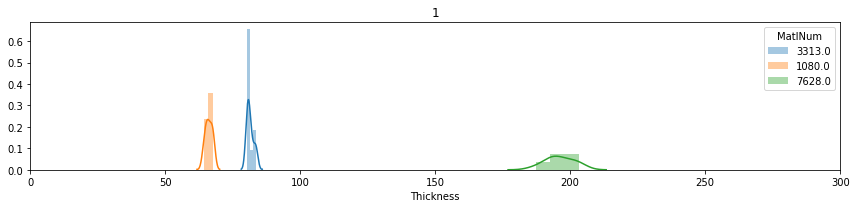

,Thickness,count
MatlG,,
46.8,66.215,10
81.4,81.526,10
203.4,196.097,10


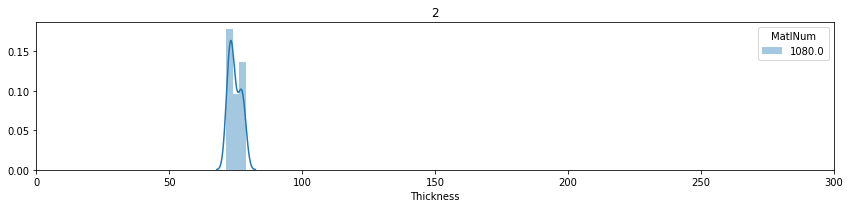

,Thickness,count
MatlG,,
46.8,74.637,30


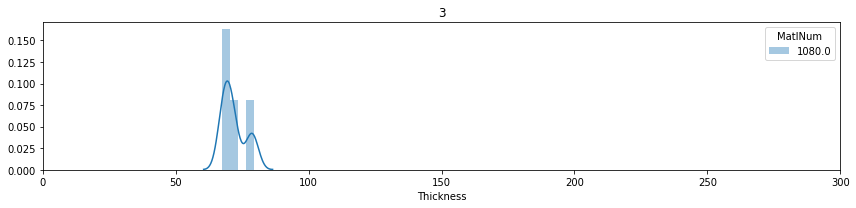

,Thickness,count
MatlG,,
46.8,71.8775,20


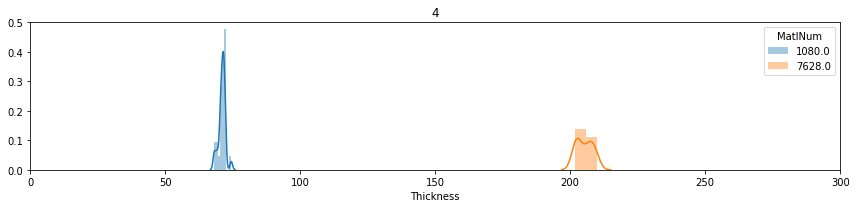

,Thickness,count
MatlG,,
46.8,71.10,30
203.4,205.32,20


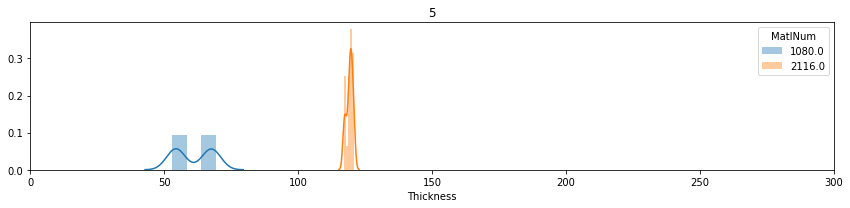

,Thickness,count
MatlG,,
46.8,61.03175,40
103.8,119.24850,40


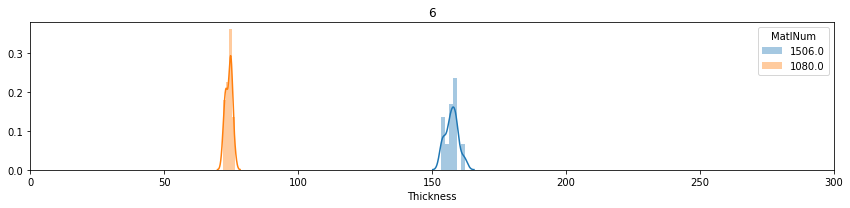

,Thickness,count
MatlG,,
46.8,74.17850,20
165.0,157.38825,40


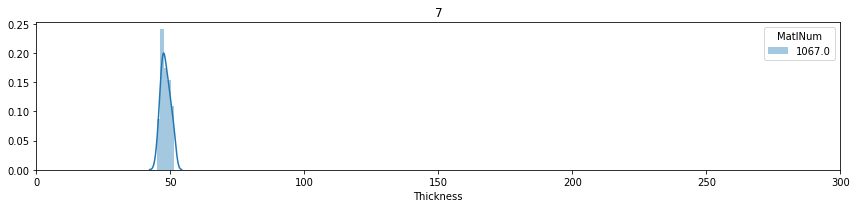

,Thickness,count
MatlG,,
31.0,48.213714,35


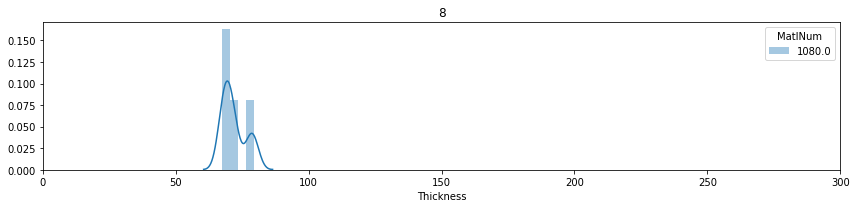

,Thickness,count
MatlG,,
46.8,71.8775,20


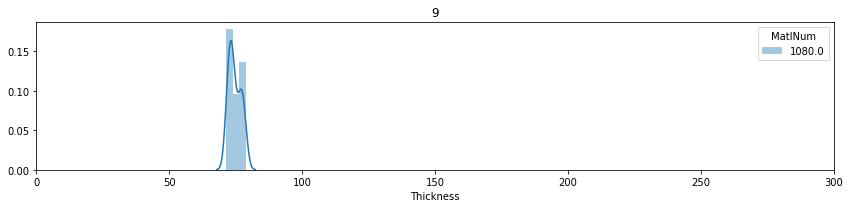

,Thickness,count
MatlG,,
46.8,74.637,30


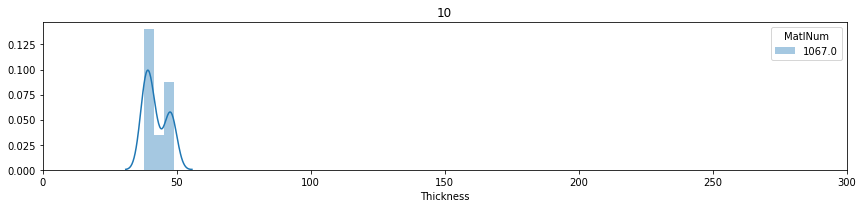

,Thickness,count
MatlG,,
31.0,42.175333,30


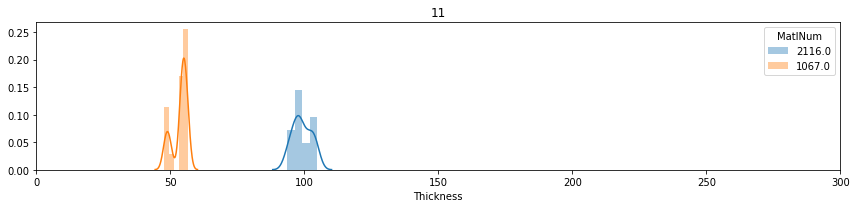

,Thickness,count
MatlG,,
31.0,53.525000,20
103.8,99.134333,30


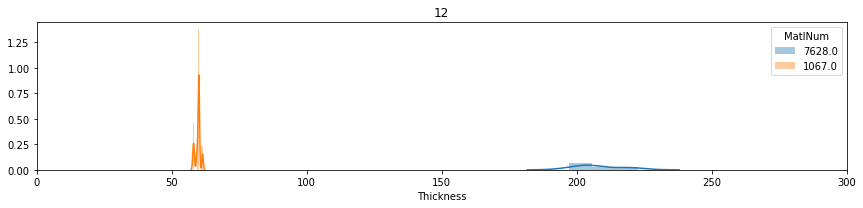

,Thickness,count
MatlG,,
31.0,59.773,10
203.4,208.108,15


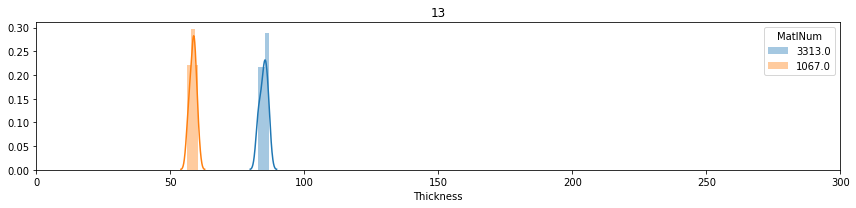

,Thickness,count
MatlG,,
31.0,58.419,10
81.4,84.812,10


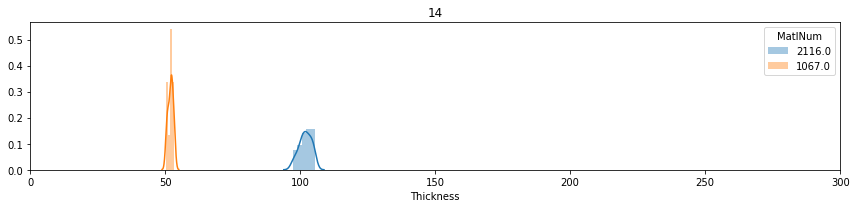

,Thickness,count
MatlG,,
31.0,52.0345,20
103.8,101.9085,40


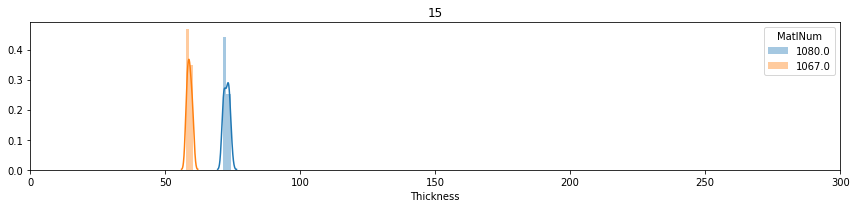

,Thickness,count
MatlG,,
31.0,59.006,10
46.8,72.774,15


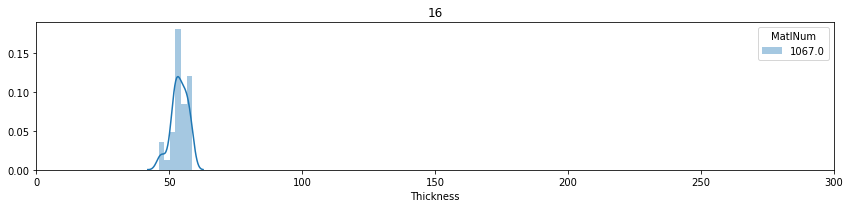

,Thickness,count
MatlG,,
31.0,53.849,40


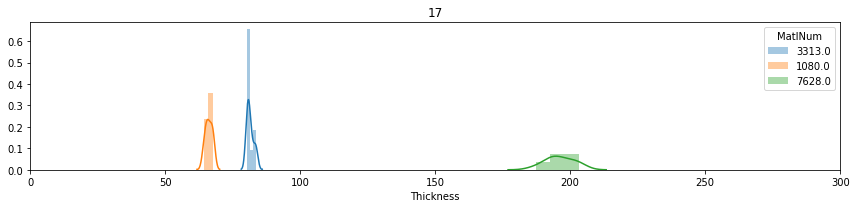

,Thickness,count
MatlG,,
46.8,66.215,10
81.4,81.526,10
203.4,196.097,10


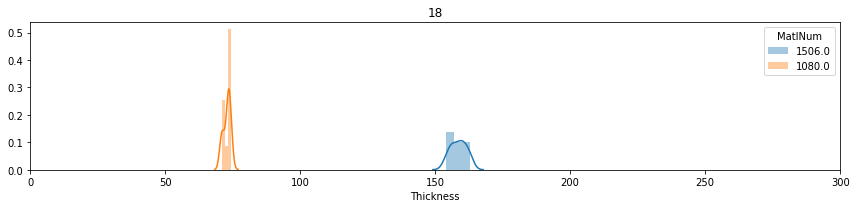

,Thickness,count
MatlG,,
46.8,72.890,10
165.0,158.625,20


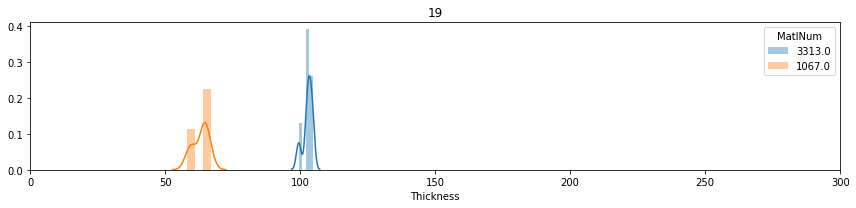

,Thickness,count
MatlG,,
31.0,63.130833,12
81.4,102.850000,12


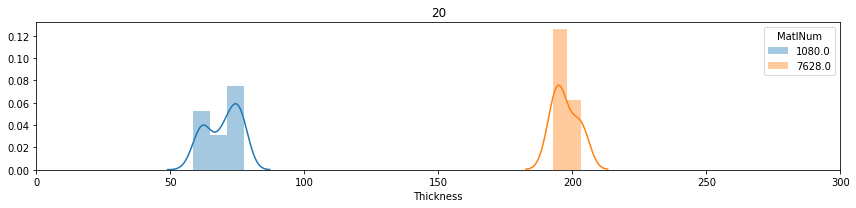

,Thickness,count
MatlG,,
46.8,69.602778,36
203.4,197.385000,6


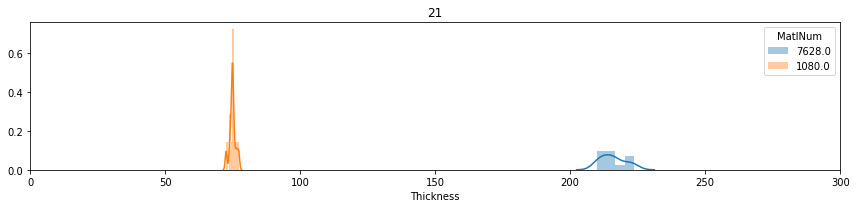

,Thickness,count
MatlG,,
46.8,75.000,12
203.4,215.795,24


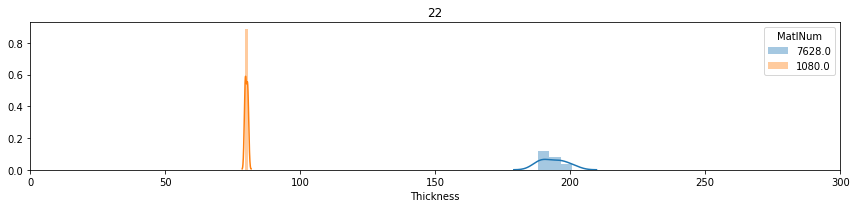

,Thickness,count
MatlG,,
46.8,80.135000,6
203.4,193.684167,12


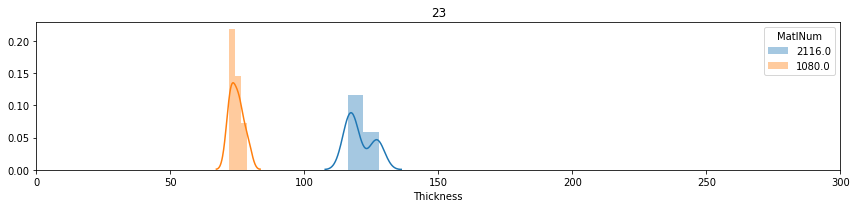

,Thickness,count
MatlG,,
46.8,74.680000,6
103.8,120.642222,18


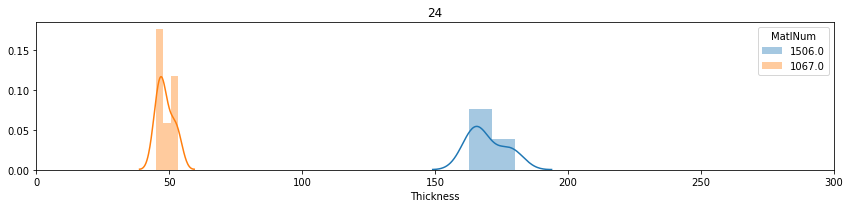

,Thickness,count
MatlG,,
31.0,48.426667,6
165.0,169.495556,9


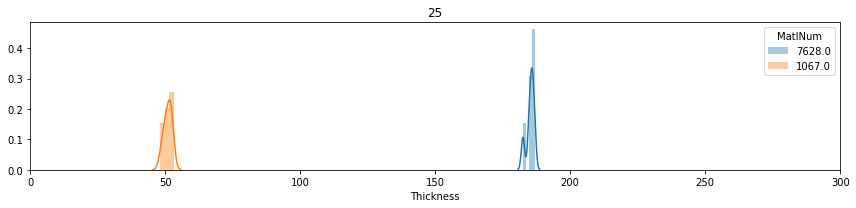

,Thickness,count
MatlG,,
31.0,51.011667,12
203.4,185.250833,12


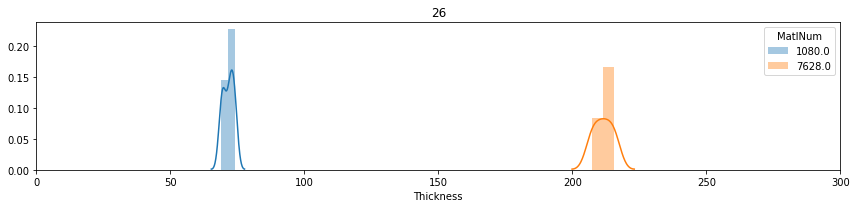

,Thickness,count
MatlG,,
46.8,71.621667,18
203.4,211.520000,3


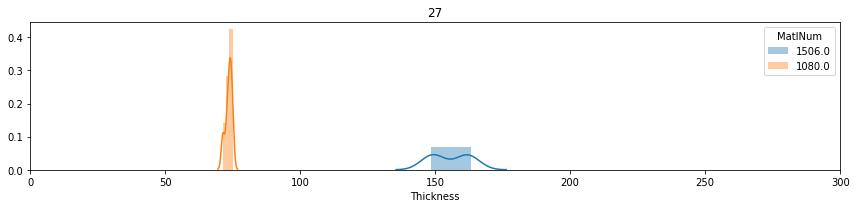

,Thickness,count
MatlG,,
46.8,73.563333,6
165.0,155.567500,12


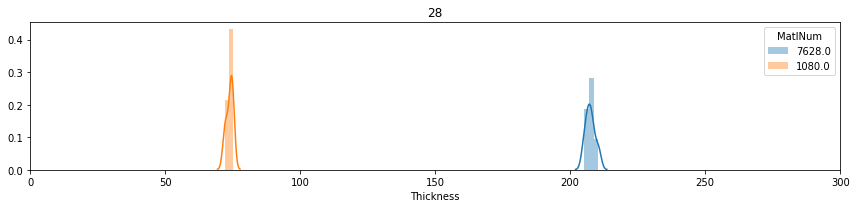

,Thickness,count
MatlG,,
46.8,73.906667,6
203.4,207.496667,12


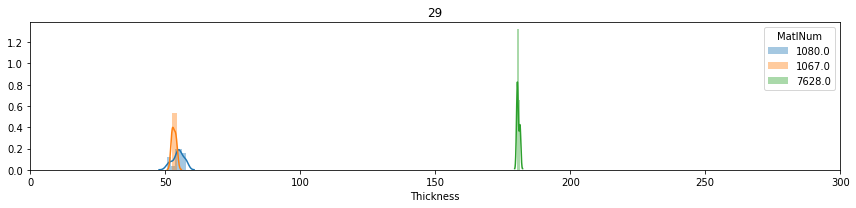

,Thickness,count
MatlG,,
31.0,53.268333,6
46.8,54.817222,18
203.4,180.756667,3


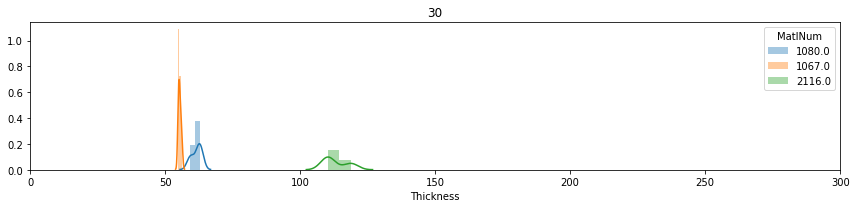

,Thickness,count
MatlG,,
31.0,55.406667,6
46.8,61.636667,6
103.8,113.140000,3


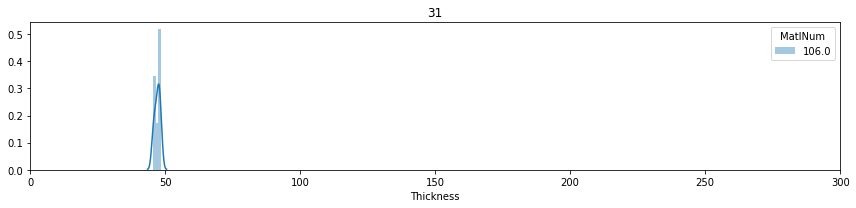

,Thickness,count
MatlG,,
24.4,47.13,6


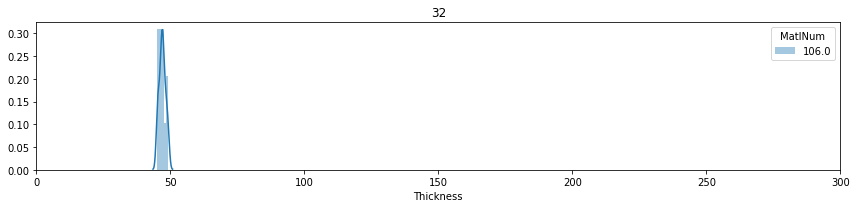

,Thickness,count
MatlG,,
24.4,47.01,12


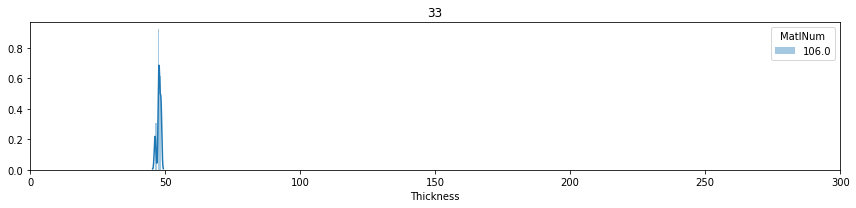

,Thickness,count
MatlG,,
24.4,47.733333,6


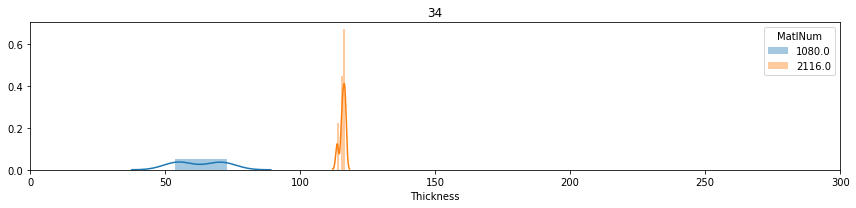

,Thickness,count
MatlG,,
46.8,62.812500,12
103.8,115.746667,12


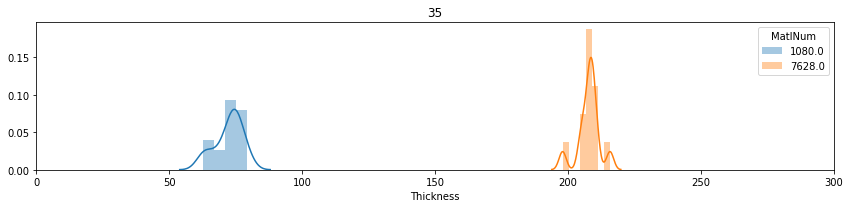

,Thickness,count
MatlG,,
46.8,72.332222,18
203.4,207.841667,12


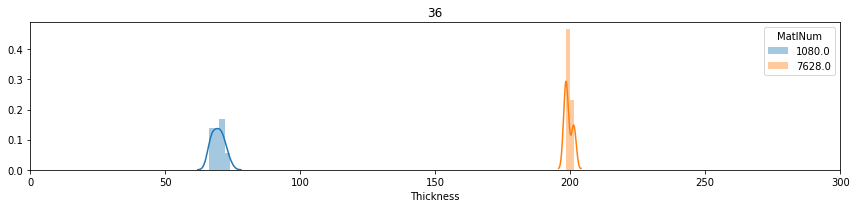

,Thickness,count
MatlG,,
46.8,69.557778,18
203.4,199.413333,3


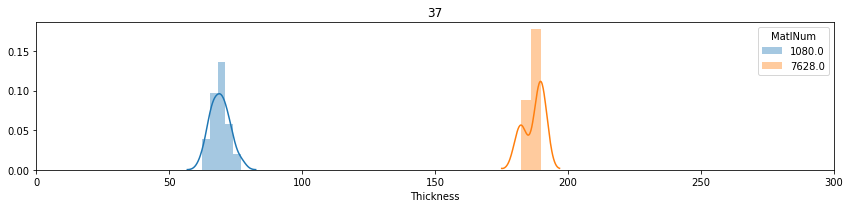

,Thickness,count
MatlG,,
46.8,68.995,18
203.4,187.170,3


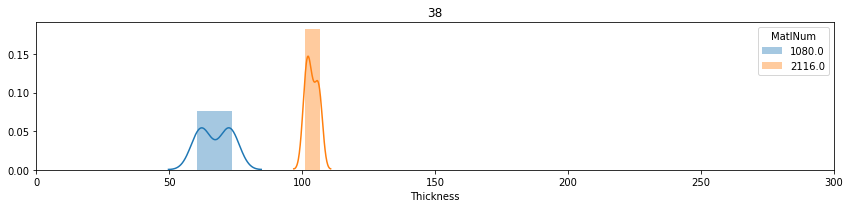

,Thickness,count
MatlG,,
46.8,67.2675,12
103.8,103.6775,12


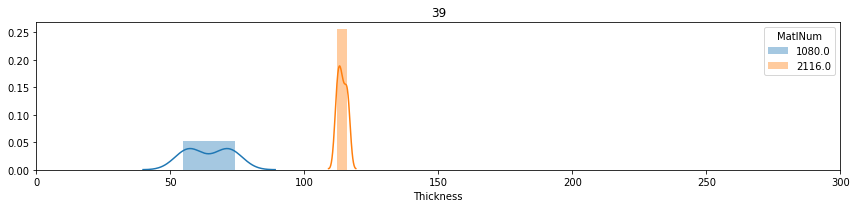

,Thickness,count
MatlG,,
46.8,64.265833,12
103.8,114.112500,12


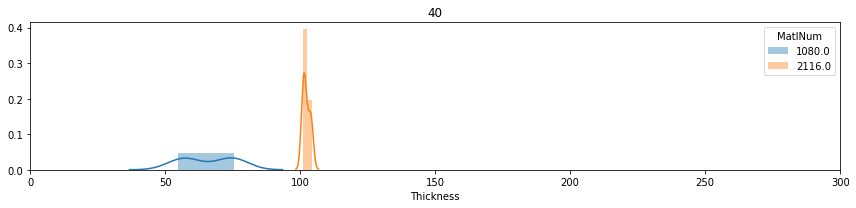

,Thickness,count
MatlG,,
46.8,65.925833,12
103.8,102.341667,12


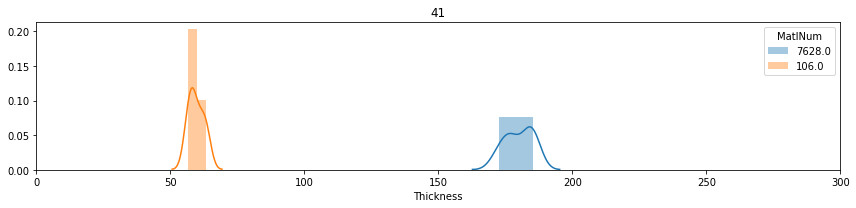

,Thickness,count
MatlG,,
24.4,59.641667,6
203.4,180.044167,12


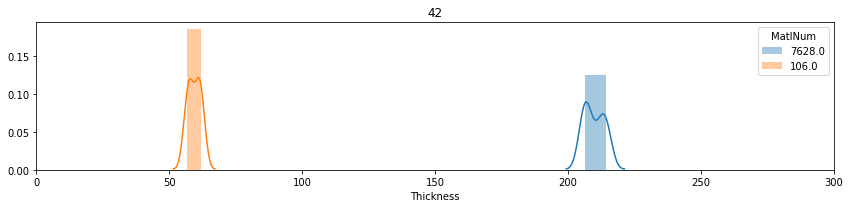

,Thickness,count
MatlG,,
24.4,59.395000,6
203.4,209.824167,12


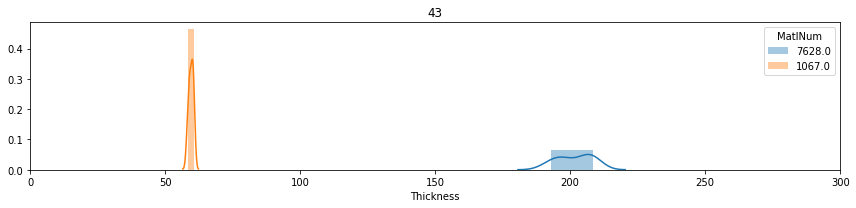

,Thickness,count
MatlG,,
31.0,59.618333,6
203.4,201.577500,12


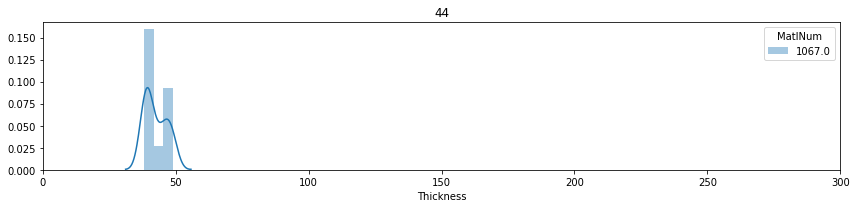

,Thickness,count
MatlG,,
31.0,42.414762,21


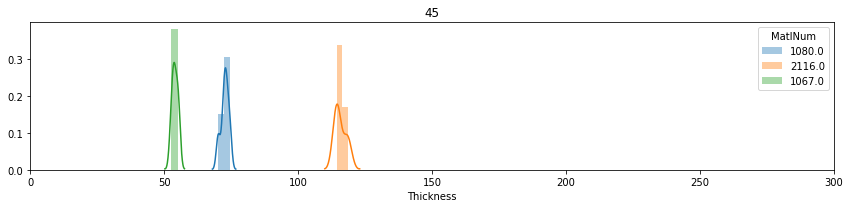

,Thickness,count
MatlG,,
31.0,54.091667,6
46.8,72.703333,6
103.8,115.856667,6


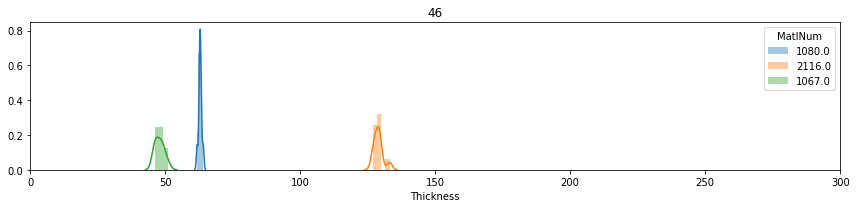

,Thickness,count
MatlG,,
31.0,47.946,10
46.8,62.992,10
103.8,128.970,10


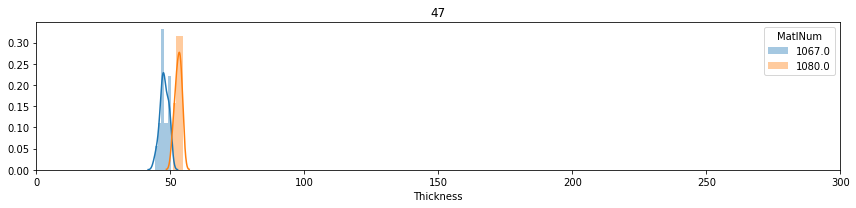

,Thickness,count
MatlG,,
31.0,47.702,30
46.8,52.938,10


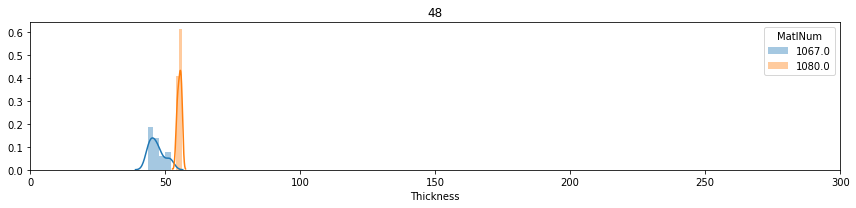

,Thickness,count
MatlG,,
31.0,46.850667,30
46.8,55.335000,10


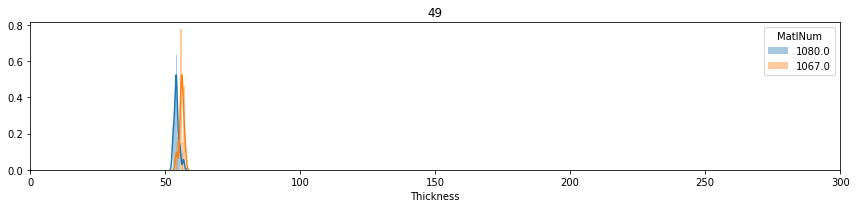

,Thickness,count
MatlG,,
31.0,56.128,10
46.8,54.212,20


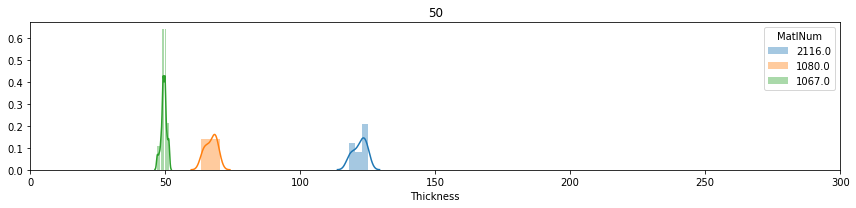

,Thickness,count
MatlG,,
31.0,49.5695,20
46.8,67.0185,20
103.8,122.0590,20


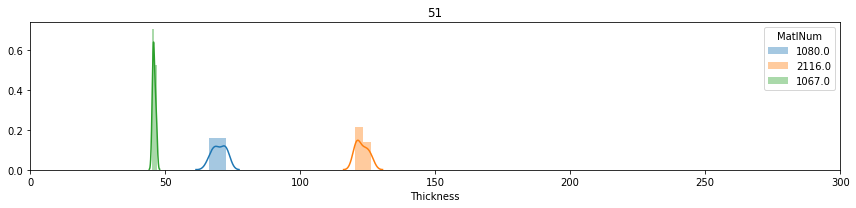

,Thickness,count
MatlG,,
31.0,45.951,10
46.8,69.998,10
103.8,122.899,10


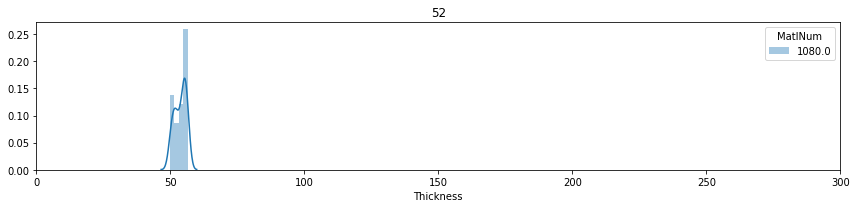

,Thickness,count
MatlG,,
46.8,53.685714,35


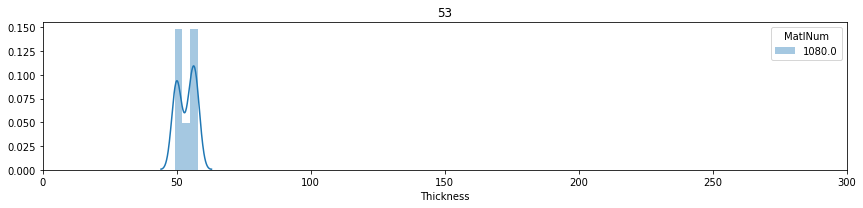

,Thickness,count
MatlG,,
46.8,53.542286,35


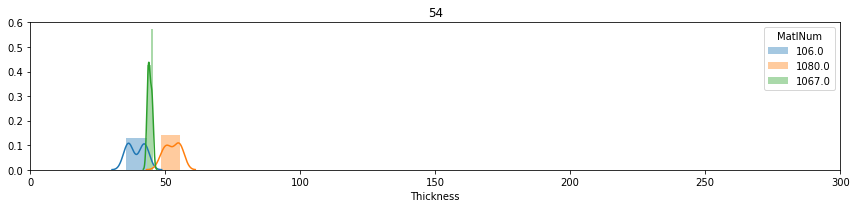

,Thickness,count
MatlG,,
24.4,39.3545,20
31.0,44.3410,10
46.8,52.7120,10


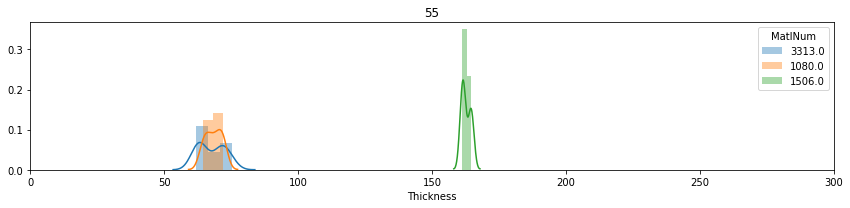

,Thickness,count
MatlG,,
46.8,68.498667,15
81.4,67.655500,20
165.0,162.788000,10


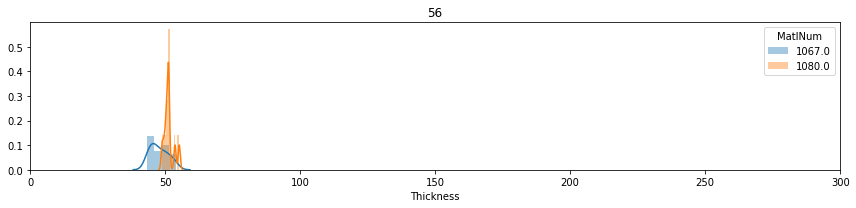

,Thickness,count
MatlG,,
31.0,47.771,30
46.8,51.361,10


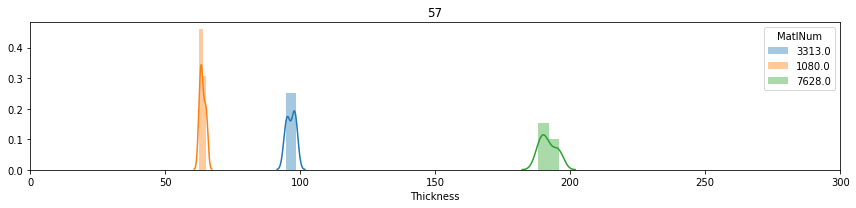

,Thickness,count
MatlG,,
46.8,63.915,10
81.4,96.623,10
203.4,191.743,10


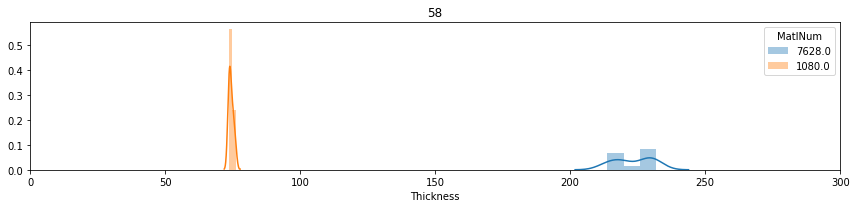

,Thickness,count
MatlG,,
46.8,74.438,10
203.4,223.396,20


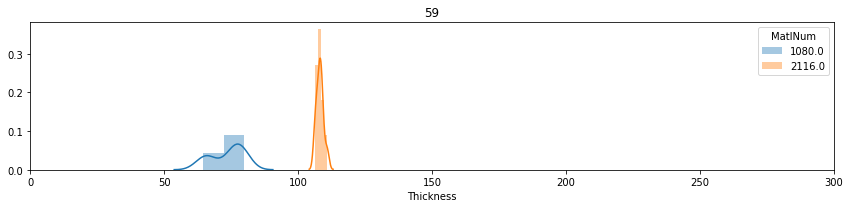

,Thickness,count
MatlG,,
46.8,73.550667,15
103.8,108.198000,10


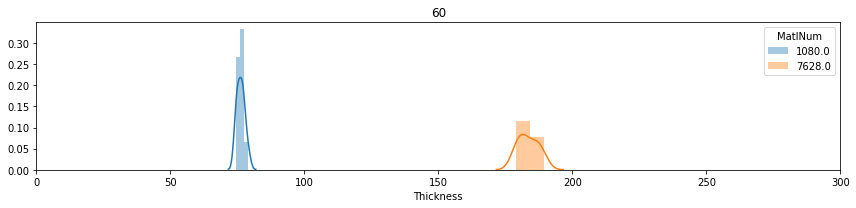

,Thickness,count
MatlG,,
46.8,76.263,10
203.4,183.545,10


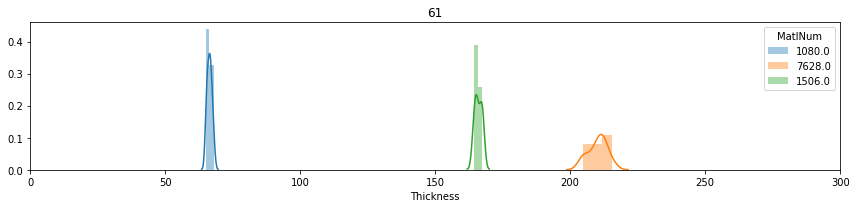

,Thickness,count
MatlG,,
46.8,66.459,10
165.0,166.014,10
203.4,210.195,10


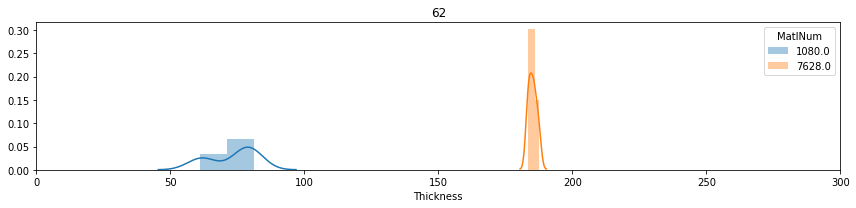

,Thickness,count
MatlG,,
46.8,73.168,15
203.4,185.184,10


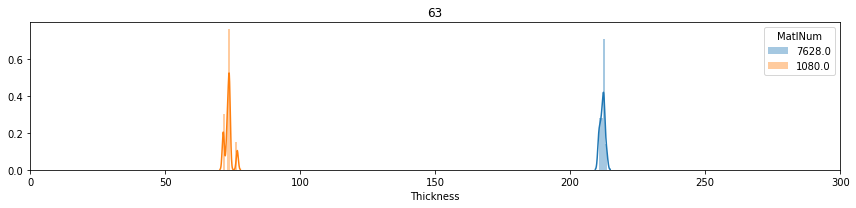

,Thickness,count
MatlG,,
46.8,73.450,10
203.4,211.958,20


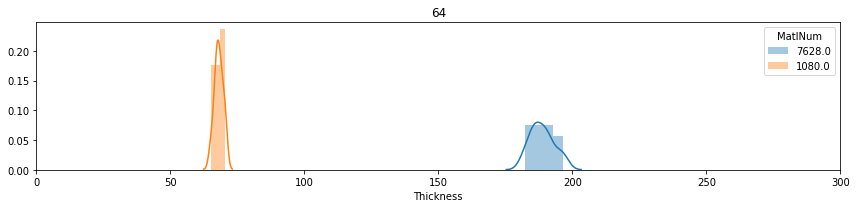

,Thickness,count
MatlG,,
46.8,68.073000,10
203.4,188.742667,15


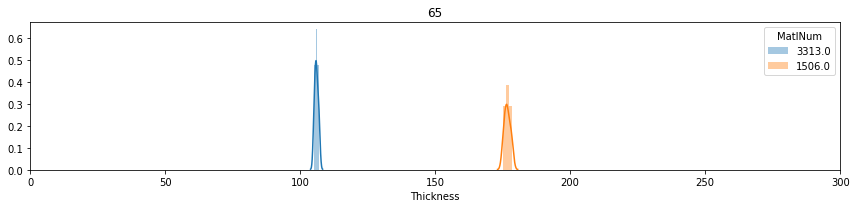

,Thickness,count
MatlG,,
81.4,106.044,10
165.0,176.738,10


In [46]:
for i in range(len(dic_model.keys())):
    key = dic_model.keys()[i]
    value = dic_model[key]
    d_1 = df[df["Model"]==key]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    matlg_list =d_1["MatlG"].value_counts().keys()
    i = 0
    plt.figure(figsize=(12, 3))
    for matl in matlg_list:
        df_2 = d_1[d_1["MatlG"]==matl]["Thickness"]
        sns.distplot(df_2,color=colors[i], label=dic_num_g[matl])
        i += 1
    plt.xlim([0,300])
    plt.legend(title="MatlNum")
    plt.xlabel("Thickness")
    plt.title(key)
    plt.tight_layout()
    plt.show()

    index_ = pd.DataFrame(d_1["Thickness"].groupby(d_1["MatlG"]).mean())
    index_["count"] = d_1["MatlG"].value_counts()
    display(index_)

## 2. Maker 별

In [47]:
dic_model = df["MatlMaker"].value_counts().sort_values()
dic_model

NPG-151       60
EM-526        72
IT150G        81
EM-370Z      128
DS7402LC     405
DS7402M     1146
Name: MatlMaker, dtype: int64

### 2.1 total

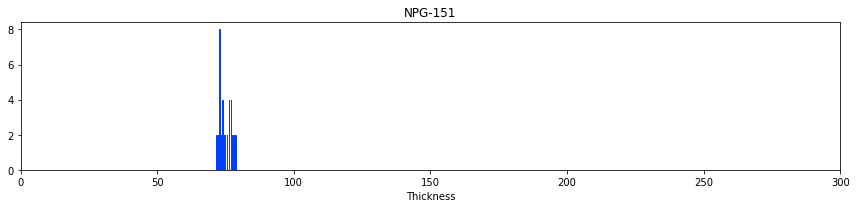

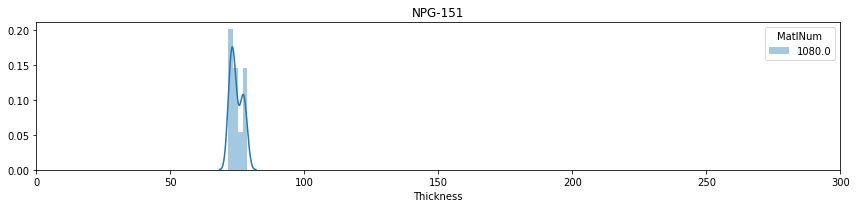

,Thickness,count
MatlG,,
46.8,74.637,60


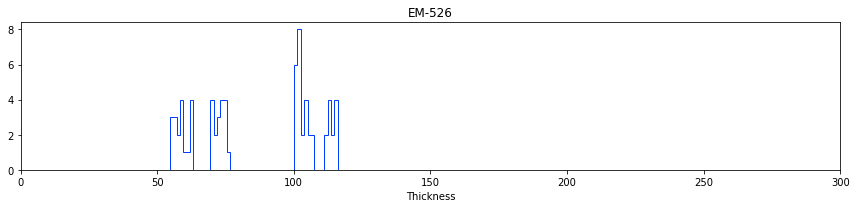

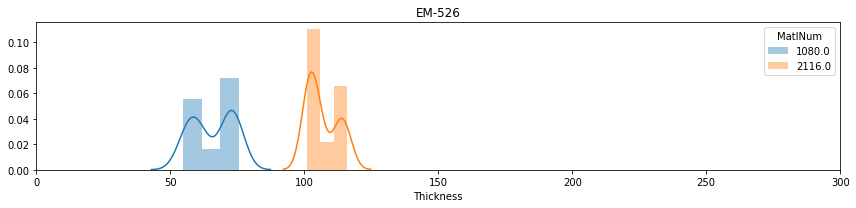

,Thickness,count
MatlG,,
46.8,65.819722,36
103.8,106.710556,36


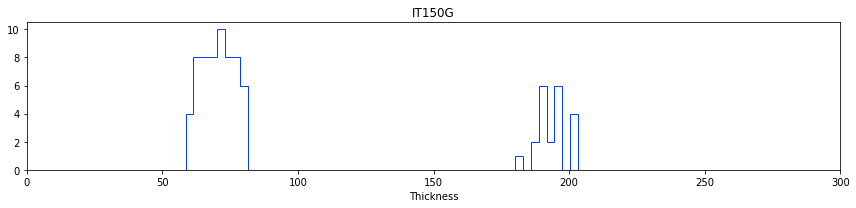

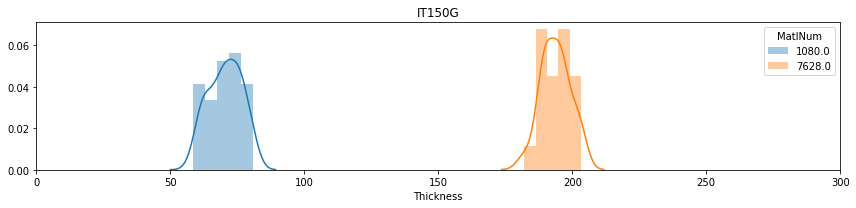

,Thickness,count
MatlG,,
46.8,70.473667,60
203.4,193.810952,21


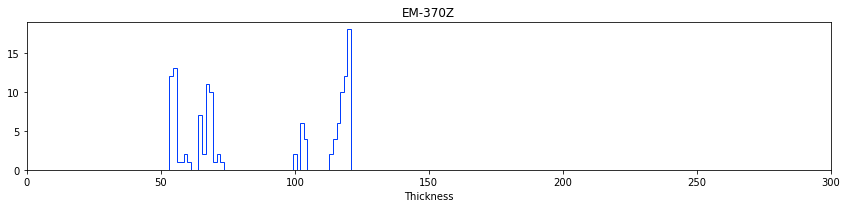

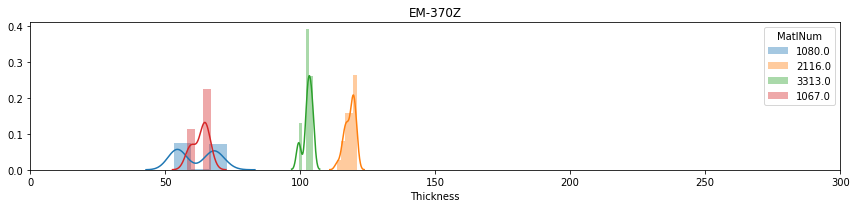

,Thickness,count
MatlG,,
31.0,63.130833,12
46.8,61.442692,52
81.4,102.850000,12
103.8,118.440385,52


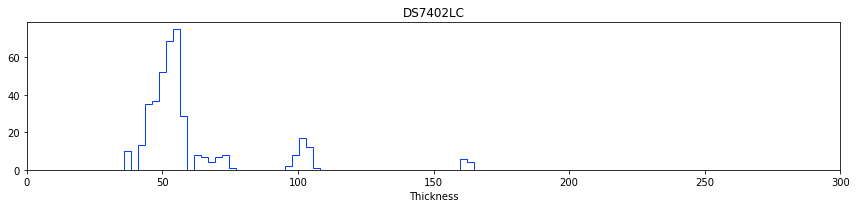

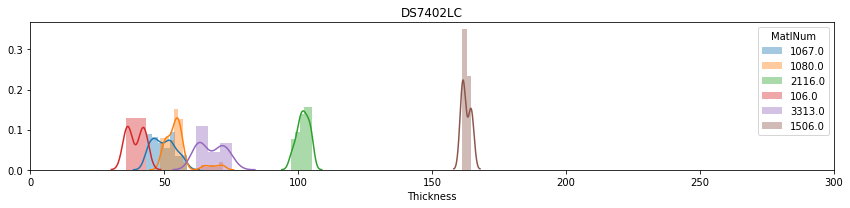

,Thickness,count
MatlG,,
24.4,39.354500,20
31.0,49.817941,170
46.8,55.090759,145
81.4,67.655500,20
103.8,101.908500,40
165.0,162.788000,10


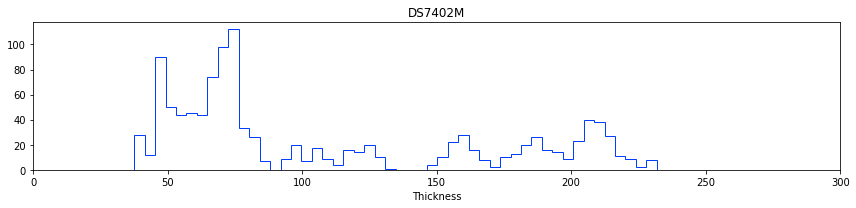

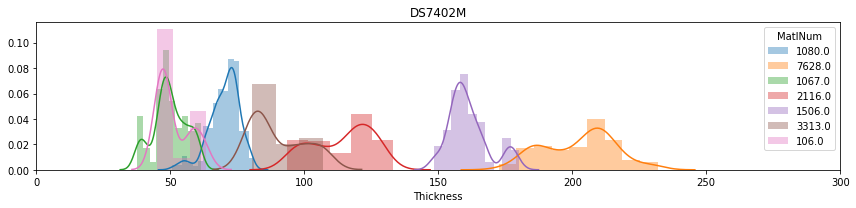

,Thickness,count
MatlG,,
24.4,51.320000,36
31.0,49.785780,218
46.8,70.190950,379
81.4,90.106200,50
103.8,114.224299,107
165.0,161.265545,101
203.4,202.562431,255


In [48]:
# pp ccl 구분 nope
len_ = len(dic_model.keys())
#plt.figure(figsize=(12, 10))
for i in range(len(dic_model.keys())):
    key = dic_model.keys()[i]
    value = dic_model[key]
    d_1 = df[df["MatlMaker"]==key]
    
    d_ = d_1["Thickness"]
    plt.figure(figsize=(12, 3))
    #plt.subplot(len_,1,i+1)
    plt.hist( d_, bins=50, histtype='step', label='histogram' )
    #display(d_1.loc[:,["MatlG","Thickness"]].head())
    #keys = data["MatlG"].groupby(data["MatlNum"]).mean().keys()
    
    plt.xlabel("Thickness")
    plt.xlim([0,300])
    plt.title(key)
    plt.tight_layout()
    plt.show()
    
    
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    matlg_list =d_1["MatlG"].value_counts().keys()
    i = 0
    plt.figure(figsize=(12, 3))
    for matl in matlg_list:
        df_2 = d_1[d_1["MatlG"]==matl]["Thickness"]
        sns.distplot(df_2,color=colors[i], label=dic_num_g[matl])
        i += 1
    plt.xlim([0,300])
    plt.legend(title="MatlNum")
    plt.xlabel("Thickness")
    plt.title(key)
    plt.tight_layout()
    plt.show()

    index_ = pd.DataFrame(d_1["Thickness"].groupby(d_1["MatlG"]).mean())
    index_["count"] = d_1["MatlG"].value_counts()
    display(index_)


## Glass 별

In [49]:
dic_model = df["MatlG"].value_counts().sort_values()
dic_model

24.4      56
81.4      82
165.0    111
103.8    235
203.4    276
31.0     400
46.8     732
Name: MatlG, dtype: int64

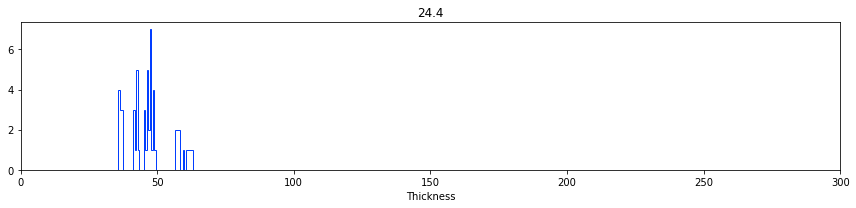

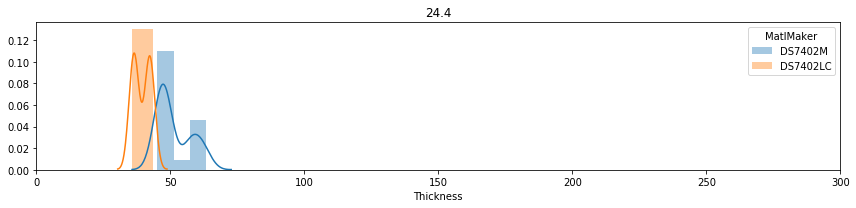

,Thickness,count
MatlMaker,,
DS7402LC,39.3545,20
DS7402M,51.3200,36


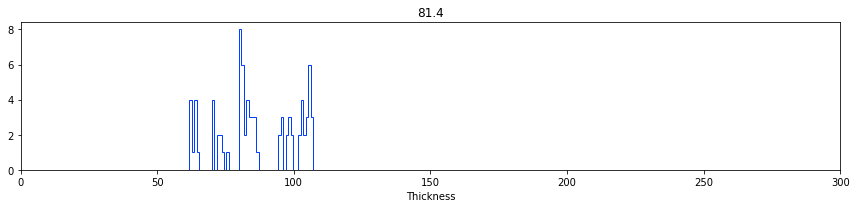

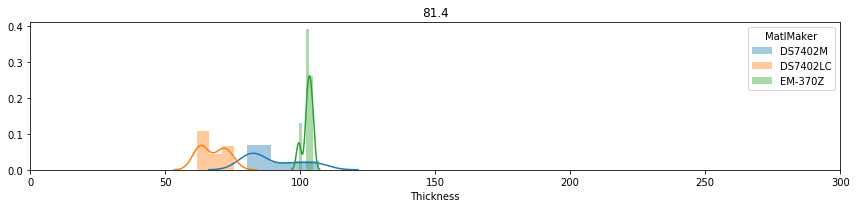

,Thickness,count
MatlMaker,,
DS7402LC,67.6555,20
DS7402M,90.1062,50
EM-370Z,102.8500,12


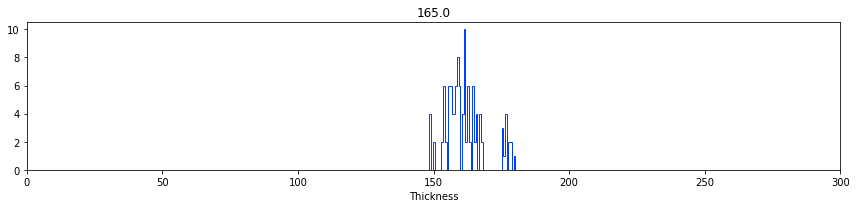

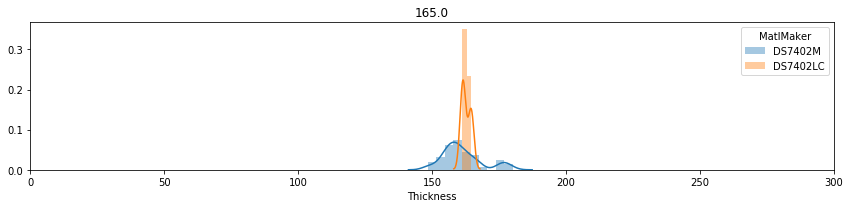

,Thickness,count
MatlMaker,,
DS7402LC,162.788000,10
DS7402M,161.265545,101


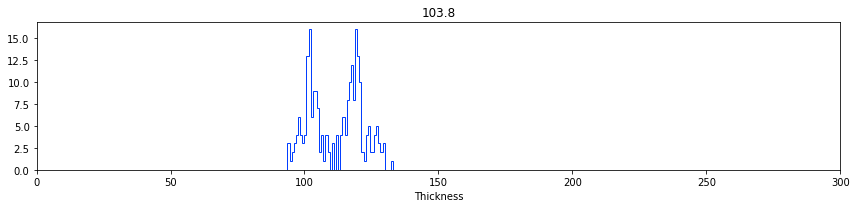

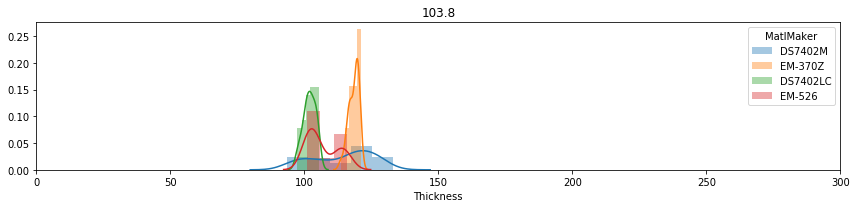

,Thickness,count
MatlMaker,,
DS7402LC,101.908500,40
DS7402M,114.224299,107
EM-370Z,118.440385,52
EM-526,106.710556,36


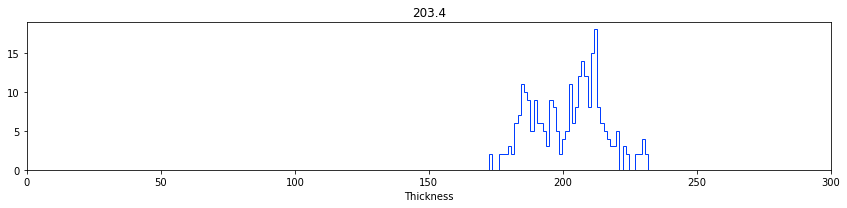

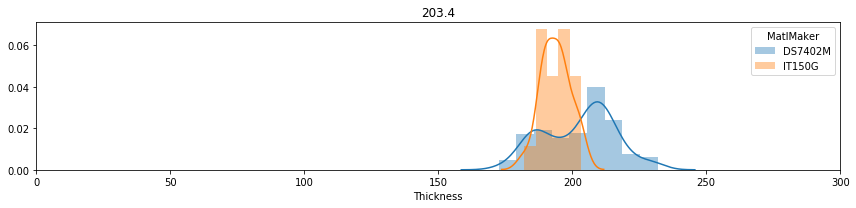

,Thickness,count
MatlMaker,,
DS7402M,202.562431,255
IT150G,193.810952,21


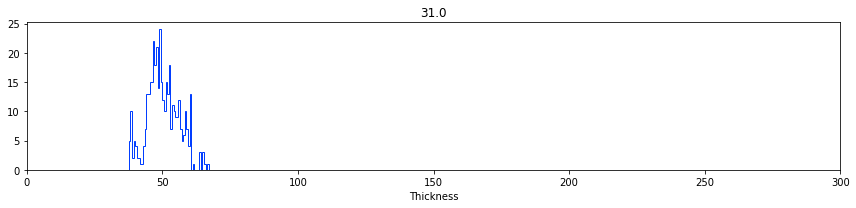

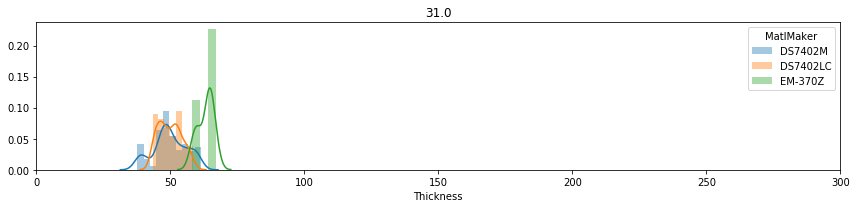

,Thickness,count
MatlMaker,,
DS7402LC,49.817941,170
DS7402M,49.785780,218
EM-370Z,63.130833,12


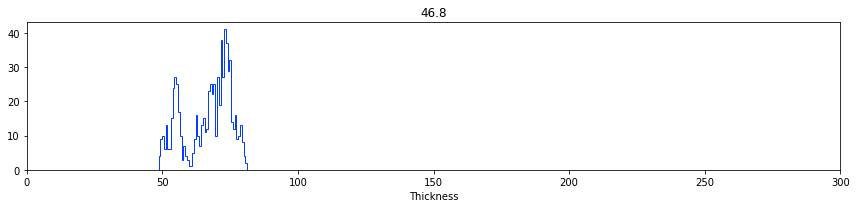

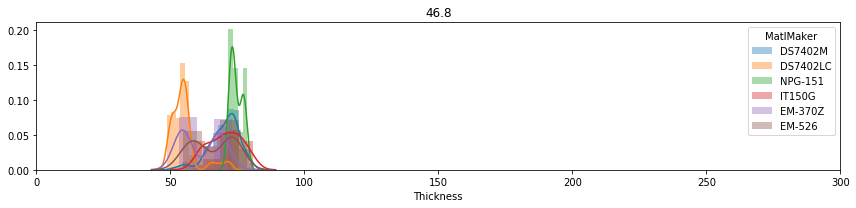

,Thickness,count
MatlMaker,,
DS7402LC,55.090759,145
DS7402M,70.190950,379
EM-370Z,61.442692,52
EM-526,65.819722,36
IT150G,70.473667,60
NPG-151,74.637000,60


In [50]:
# pp ccl 구분 nope
len_ = len(dic_model.keys())
#plt.figure(figsize=(12, 10))
for i in range(len(dic_model.keys())):
    key = dic_model.keys()[i]
    value = dic_model[key]
    d_1 = df[df["MatlG"]==key]
    
    d_ = d_1["Thickness"]
    plt.figure(figsize=(12, 3))
    #plt.subplot(len_,1,i+1)
    plt.hist( d_, bins=50, histtype='step', label='histogram' )
    #display(d_1.loc[:,["MatlG","Thickness"]].head())
    #keys = data["MatlG"].groupby(data["MatlNum"]).mean().keys()
    
    plt.xlabel("Thickness")
    plt.xlim([0,300])
    plt.title(key)
    plt.tight_layout()
    plt.show()
    
    
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    matlg_list =d_1["MatlMaker"].value_counts().keys()
    i = 0
    plt.figure(figsize=(12, 3))
    for matl in matlg_list:
        df_2 = d_1[d_1["MatlMaker"]==matl]["Thickness"]
        sns.distplot(df_2,color=colors[i], label=matl)
        i += 1
    plt.xlim([0,300])
    plt.legend(title="MatlMaker")
    plt.xlabel("Thickness")
    plt.title(key)
    plt.tight_layout()
    plt.show()

    index_ = pd.DataFrame(d_1["Thickness"].groupby(d_1["MatlMaker"]).mean())
    index_["count"] = d_1["MatlMaker"].value_counts()
    display(index_)


# K-means

In [51]:
data_2.head()

,Model,LayerNum,PP,MatlMaker,MatlNum,RC,MatlG,Cu1,CP1,Cu2,CP2,Input_T,Thickness
0,1,1,1,DS7402M,1080.0,61.0,46.8,8.21,55,14.29,73,60,67.70
1,1,2,0,DS7402M,0.0,0.0,0.0,14.29,73,15.04,56,75,73.71
2,1,3,1,DS7402M,7628.0,47.0,203.4,15.04,56,14.58,46,200,187.25
3,1,4,0,DS7402M,0.0,0.0,0.0,14.58,46,14.29,75,75,77.47
4,1,5,1,DS7402M,3313.0,53.0,81.4,14.29,75,15.04,48,90,80.48


In [52]:
data_2["MatlMaker"].value_counts()

DS7402M     1809
DS7402LC     635
EM-370Z      218
IT150G       126
EM-526       117
NPG-151      110
Name: MatlMaker, dtype: int64

In [53]:
data_2.drop(columns="Thickness").head()

,Model,LayerNum,PP,MatlMaker,MatlNum,RC,MatlG,Cu1,CP1,Cu2,CP2,Input_T
0,1,1,1,DS7402M,1080.0,61.0,46.8,8.21,55,14.29,73,60
1,1,2,0,DS7402M,0.0,0.0,0.0,14.29,73,15.04,56,75
2,1,3,1,DS7402M,7628.0,47.0,203.4,15.04,56,14.58,46,200
3,1,4,0,DS7402M,0.0,0.0,0.0,14.58,46,14.29,75,75
4,1,5,1,DS7402M,3313.0,53.0,81.4,14.29,75,15.04,48,90


### Thickenss 미포함

In [54]:
### CCL 과 PP 같이 

data_ = data_2.copy()
data_ = data_.drop(columns="Thickness")
data_["MatlMaker_cate"] = data_["MatlMaker"].astype("category")
cat_col = data_.select_dtypes(["category"]).columns
data_[cat_col] = data_[cat_col].apply(lambda x: x.cat.codes)
cat_dic = {}
cat_dic["DS7402M"] = data_[data_["MatlMaker"]=="DS7402M"]["MatlMaker_cate"].iloc[0]
cat_dic["EM-370Z"] = data_[data_["MatlMaker"]=="EM-370Z"]["MatlMaker_cate"].iloc[0]
cat_dic["DS7402LC"] = data_[data_["MatlMaker"]=="DS7402LC"]["MatlMaker_cate"].iloc[0]
cat_dic["IT150G"] = data_[data_["MatlMaker"]=="IT150G"]["MatlMaker_cate"].iloc[0]
cat_dic["EM-526"] = data_[data_["MatlMaker"]=="EM-526"]["MatlMaker_cate"].iloc[0]
cat_dic["NPG-151"] = data_[data_["MatlMaker"]=="NPG-151"]["MatlMaker_cate"].iloc[0]
data_= data_.drop(columns="MatlMaker")
data_.head()

,Model,LayerNum,PP,MatlNum,RC,MatlG,Cu1,CP1,Cu2,CP2,Input_T,MatlMaker_cate
0,1,1,1,1080.0,61.0,46.8,8.21,55,14.29,73,60,1
1,1,2,0,0.0,0.0,0.0,14.29,73,15.04,56,75,1
2,1,3,1,7628.0,47.0,203.4,15.04,56,14.58,46,200,1
3,1,4,0,0.0,0.0,0.0,14.58,46,14.29,75,75,1
4,1,5,1,3313.0,53.0,81.4,14.29,75,15.04,48,90,1


In [55]:
data_.to_excel(r"C:\Users\Samsung\jupyter\Project_PCB\data\for_spss\spss_excel.xlsx")

Text(0, 0.5, 'Cumulative Explained variance')

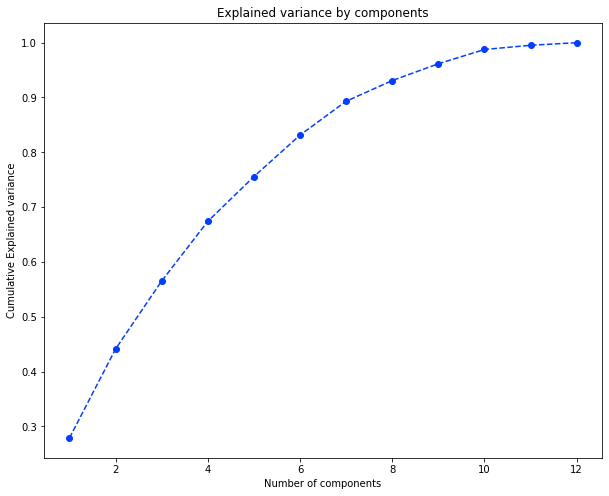

In [58]:
scaler = StandardScaler()
data_scal = scaler.fit_transform(data_)
pca = PCA()
pca.fit(data_scal)
plt.figure(figsize = (10,8))
sns.set_palette("bright")

plt.plot(range(1,13),pca.explained_variance_ratio_.cumsum(),marker="o",linestyle="--")
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative Explained variance")

In [62]:
data_scal.shape

(3015, 12)

Text(0.5, 0, 'Number of clusters')

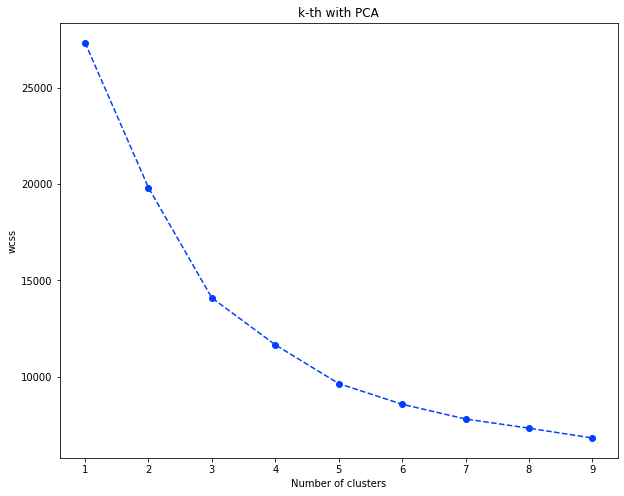

In [27]:
## 대강 compoent = 5개일때
pca = PCA(n_components=5)
pca.fit(data_scal)
data_pca = pca.transform(data_scal)
wcss = []
for i in range(1,10):
    k_mean = KMeans(n_clusters=i,init="k-means++",random_state=10)
    k_mean.fit(data_pca)
    wcss.append(k_mean.inertia_)
plt.figure(figsize = (10,8))
plt.plot(range(1,10),wcss,marker="o",linestyle="--")
plt.title("k-th with PCA")
plt.ylabel("wcss")
plt.xlabel("Number of clusters")

In [237]:
### 많이 꺾기는 부분 = k 5개 정도 
k_mean = KMeans(n_clusters=5,init="k-means++",random_state=10)
k_mean.fit(data_pca)

KMeans(n_clusters=5, random_state=10)

In [238]:
len(k_mean.labels_)

3015

In [258]:
data_concat = pd.concat([data.reset_index(drop=True),pd.DataFrame(data_pca)],axis=1)
data_concat.columns.values[-5:] = ["component 1","component 2","component 3","component 4","component 5"]
data_concat["k_means_labels"] = k_mean.labels_
data_concat["str_labels"] = data_concat["k_means_labels"].map({0:"First Group",1:"Second Group",2:"Third Group",3:"Fourth Group",4:"Fifth Group"})

data_concat["MatlG_cate"] = data_concat["MatlG"].astype("category")
cat_col = data_concat.select_dtypes(["category"]).columns
data_concat[cat_col] = data_concat[cat_col].apply(lambda x: x.cat.codes)
data_concat["MatlG_labels"] = data_concat["MatlG_cate"].map({0:"1st Glass",1:"2nd Glass"
                                                             ,2:"3rd Glass",3:"4th Glass"
                                                             ,4:"5th Glass",5:"6th Glass"
                                            
                                                             ,6:"7th Glass"})

data_concat["MatlNum_s"] = data_concat["MatlNum"].map(lambda x: "Glass {}".format(str(x).replace(".0","")) if x != 0 else "CCL")

data_concat.head()

,Model,LayerNum,PP,MatlMaker,RD,GD,MatlNum,RC,MatlG,Cu1,...,component 1,component 2,component 3,component 4,component 5,k_means_labels,str_labels,MatlG_cate,MatlG_labels,MatlNum_s
0,1,1,1,DS7402M,1.36,2.56,1080.0,61.0,46.8,8.21,...,0.599669,0.118745,-1.210457,-0.906816,-1.670092,4,Fifth Group,3,4th Glass,Glass 1080
1,1,2,0,DS7402M,1.36,2.56,0.0,0.0,0.0,14.29,...,-1.705620,-1.583017,-0.213047,0.259907,-1.311821,2,Third Group,0,1st Glass,CCL
2,1,3,1,DS7402M,1.36,2.56,7628.0,47.0,203.4,15.04,...,2.245041,-0.439602,0.572947,0.217663,-1.139567,1,Second Group,8,NaN,Glass 7628
3,1,4,0,DS7402M,1.36,2.56,0.0,0.0,0.0,14.58,...,-1.530156,-1.627619,-0.291465,-0.952090,-0.624578,2,Third Group,0,1st Glass,CCL
4,1,5,1,DS7402M,1.36,2.56,3313.0,53.0,81.4,14.29,...,0.647404,0.062285,-0.977231,0.688176,-0.633341,4,Fifth Group,5,6th Glass,Glass 3313


In [259]:
data_concat["MatlG_cate"].value_counts()

0    993
3    782
2    400
8    296
6    235
7    111
5    102
1     56
4     40
Name: MatlG_cate, dtype: int64

In [260]:
plot_dic = data_concat.loc[:,"str_labels"].value_counts()
plot_dic
bar = (
Bar()
.add_xaxis(list(plot_dic.keys()))
.add_yaxis("",list(map(float,list(plot_dic.values))))
.set_global_opts(title_opts=opts.TitleOpts(title="# Number of Groups"))
)
bar.render_notebook()

In [261]:
plot_dic = data_concat["MatlMaker"].value_counts()
plot_dic
bar = (
Bar()
.add_xaxis(list(plot_dic.keys()))
.add_yaxis("",list(map(float,list(plot_dic.values))))
.set_global_opts(title_opts=opts.TitleOpts(title="# Number of MatlMaker"))
)
bar.render_notebook()

In [262]:
plot_dic = data_concat["MatlG"].value_counts()
plot_dic
bar = (
Bar()
.add_xaxis(list(plot_dic.keys()))
.add_yaxis("",list(map(float,list(plot_dic.values))))
.set_global_opts(title_opts=opts.TitleOpts(title="# Number of MatlG"))
)
bar.render_notebook()

Text(0.5, 1.0, 'Original maker feature')

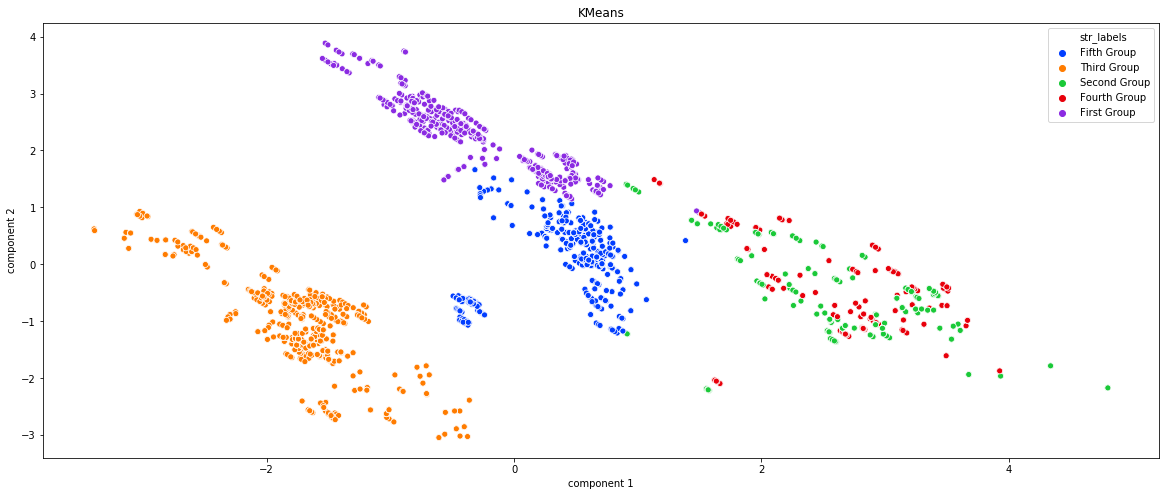

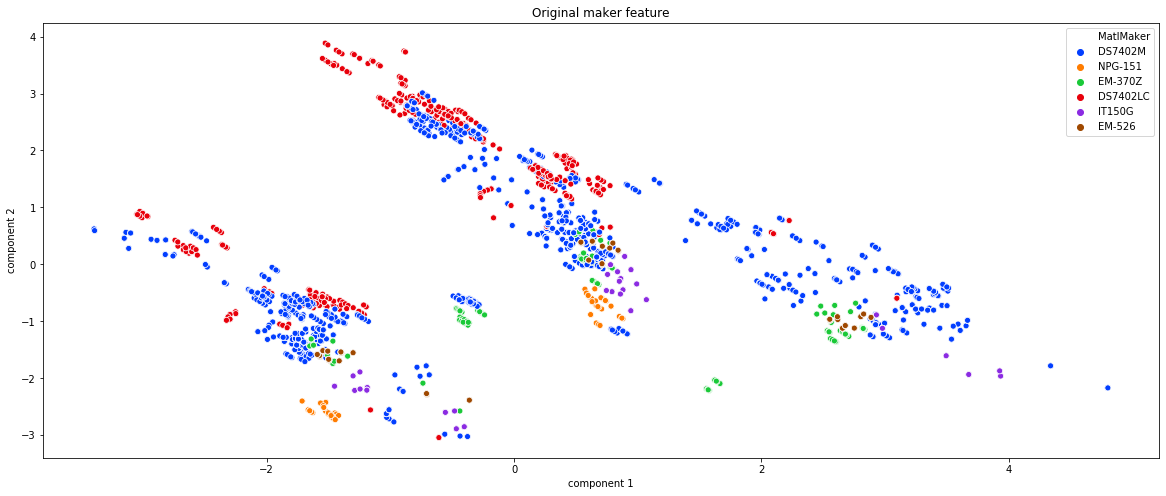

In [263]:
# visualization
x = data_concat["component 1"]
y = data_concat["component 2"]

plt.figure(figsize=(20,8))
#plt.subplot(121)
sns.scatterplot(x,y,hue=data_concat["str_labels"])
plt.title('KMeans')
#plt.subplot(122)

plt.figure(figsize=(20,8))
sns.scatterplot(x,y,hue=data_concat["MatlMaker"])
plt.title("Original maker feature")

Text(0.5, 1.0, 'Original maker feature')

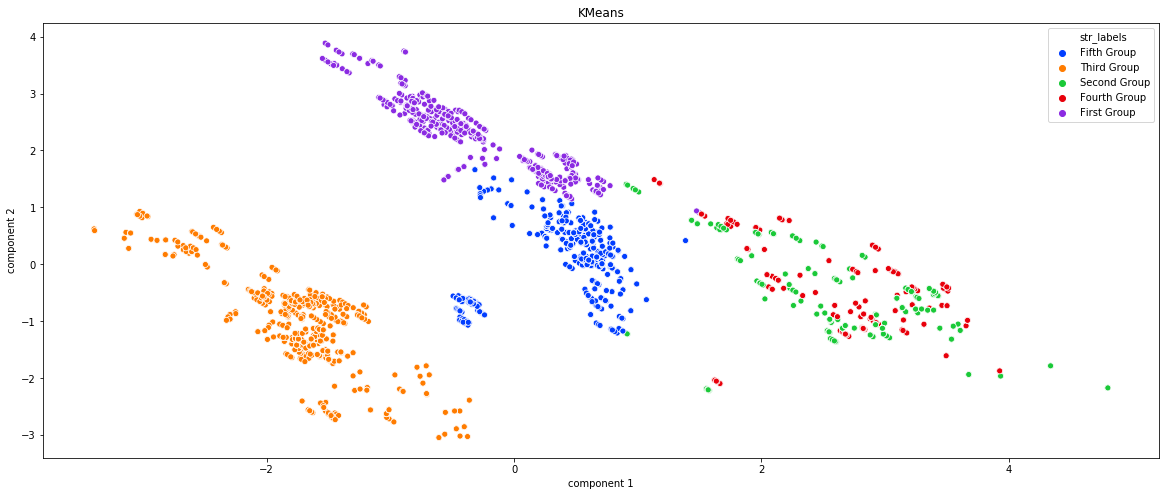

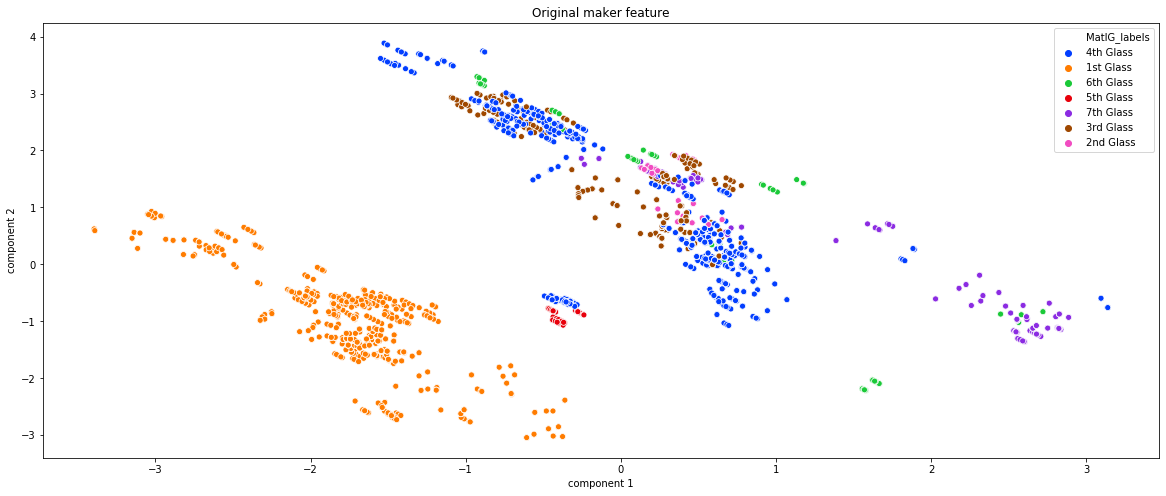

In [264]:
# visualization
x = data_concat["component 1"]
y = data_concat["component 2"]

#palette = sns.color_palette("bright")

plt.figure(figsize=(20,8))
#plt.subplot(121)
sns.set_palette("bright",7)
sns.scatterplot(x,y,hue=data_concat["str_labels"])
plt.title('KMeans')

plt.figure(figsize=(20,8))
#plt.subplot(122)

sns.scatterplot(x,y,hue=data_concat["MatlG_labels"])
#sns.set_palette("pastel")
plt.title("Original maker feature")



Text(0.5, 1.0, 'Original maker feature')

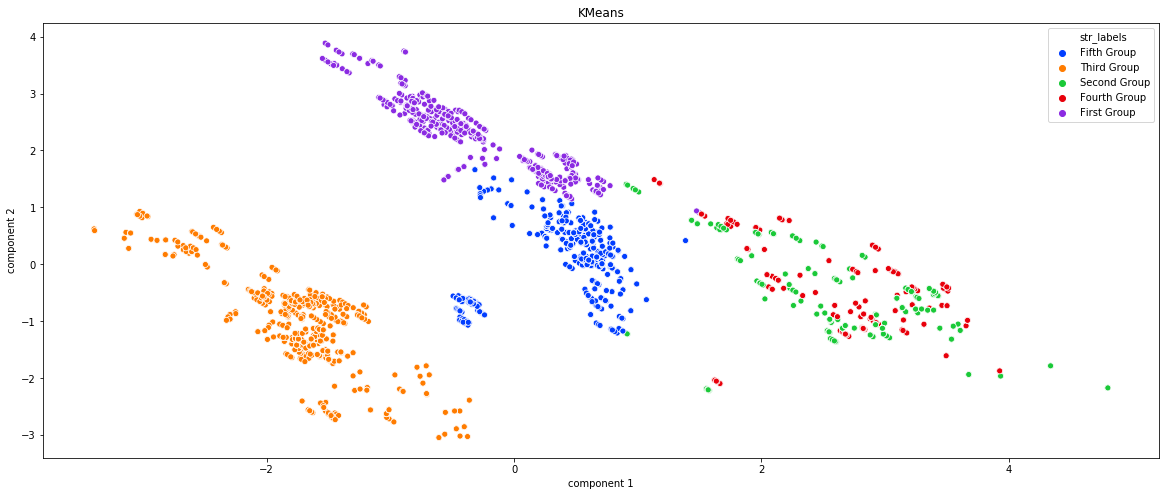

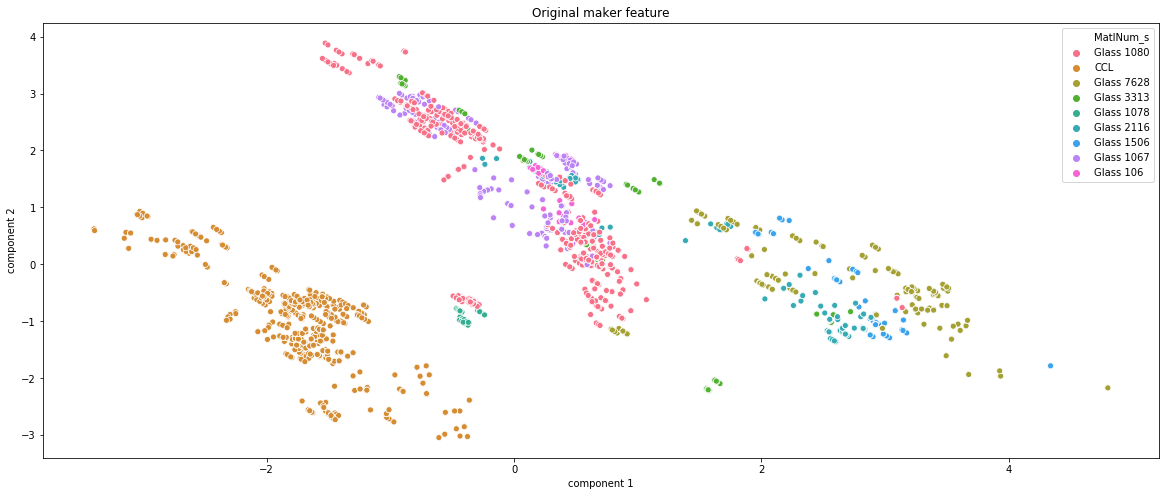

In [265]:
# visualization
x = data_concat["component 1"]
y = data_concat["component 2"]

#palette = sns.color_palette("bright")

plt.figure(figsize=(20,8))
#plt.subplot(121)
sns.set_palette("bright",7)
sns.scatterplot(x,y,hue=data_concat["str_labels"])
plt.title('KMeans')

plt.figure(figsize=(20,8))
#plt.subplot(122)

sns.scatterplot(x,y,hue=data_concat["MatlNum_s"])
#sns.set_palette("pastel")
plt.title("Original maker feature")

### 해석: 확실히 CCL과 PP 는 구분이 된다.

Text(0.5, 1.0, 'Original maker feature')

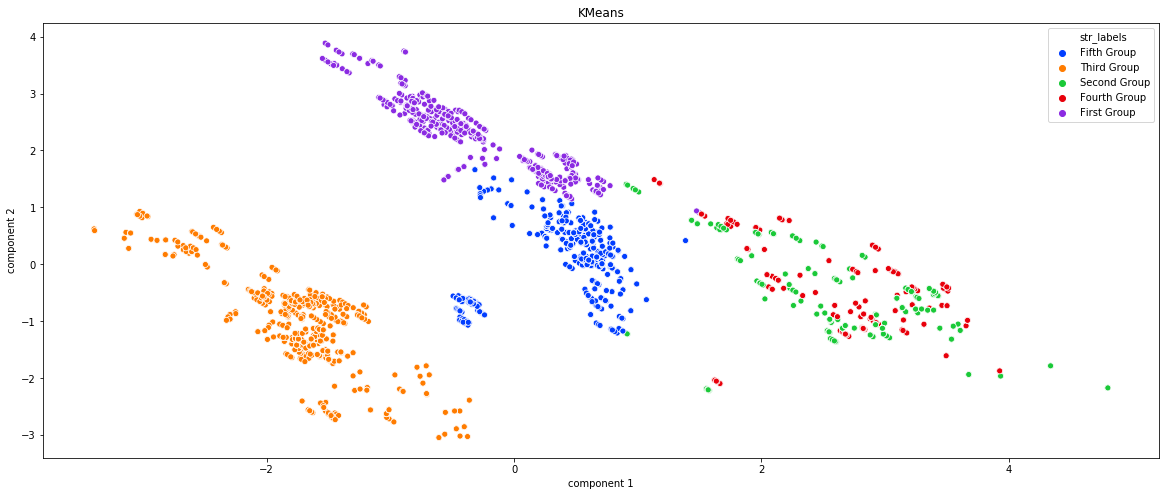

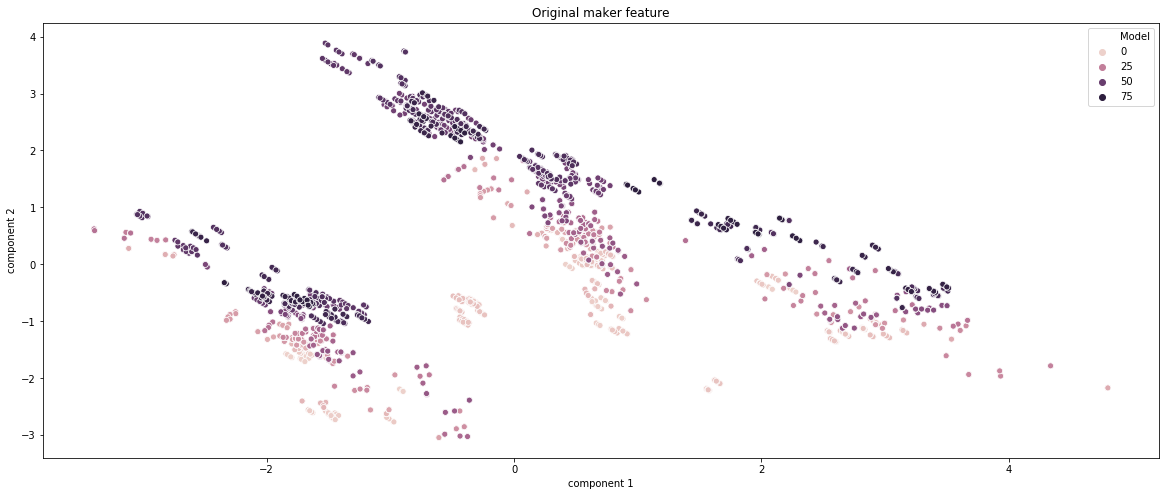

In [266]:
# visualization
x = data_concat["component 1"]
y = data_concat["component 2"]

#palette = sns.color_palette("bright")

plt.figure(figsize=(20,8))

sns.scatterplot(x,y,hue=data_concat["str_labels"])
plt.title('KMeans')

plt.figure(figsize=(20,8))
#plt.subplot(122)

sns.scatterplot(x,y,hue=data_concat["Model"])
plt.title("Original maker feature")

## K_means 다른해석 ( = profiling)

- 나뉘어진 group들이 어떠한 특징을 가지고 있는지 해석하는 작업
- 각 5개의 group들이 어떻게 구분되는가?

In [267]:
data_concat.head()

,Model,LayerNum,PP,MatlMaker,RD,GD,MatlNum,RC,MatlG,Cu1,...,component 1,component 2,component 3,component 4,component 5,k_means_labels,str_labels,MatlG_cate,MatlG_labels,MatlNum_s
0,1,1,1,DS7402M,1.36,2.56,1080.0,61.0,46.8,8.21,...,0.599669,0.118745,-1.210457,-0.906816,-1.670092,4,Fifth Group,3,4th Glass,Glass 1080
1,1,2,0,DS7402M,1.36,2.56,0.0,0.0,0.0,14.29,...,-1.705620,-1.583017,-0.213047,0.259907,-1.311821,2,Third Group,0,1st Glass,CCL
2,1,3,1,DS7402M,1.36,2.56,7628.0,47.0,203.4,15.04,...,2.245041,-0.439602,0.572947,0.217663,-1.139567,1,Second Group,8,NaN,Glass 7628
3,1,4,0,DS7402M,1.36,2.56,0.0,0.0,0.0,14.58,...,-1.530156,-1.627619,-0.291465,-0.952090,-0.624578,2,Third Group,0,1st Glass,CCL
4,1,5,1,DS7402M,1.36,2.56,3313.0,53.0,81.4,14.29,...,0.647404,0.062285,-0.977231,0.688176,-0.633341,4,Fifth Group,5,6th Glass,Glass 3313


In [270]:
## 그룹별 PP 비율
for labels_ in data_concat["str_labels"].value_counts().keys():
    data_3 = data_concat[data_concat["str_labels"]==labels_]
    print(labels_)
    print(data_3["PP"].mean())
    print()

Third Group
0.0

Fifth Group
0.8809788654060067

First Group
1.0

Second Group
0.9575163398692811

Fourth Group
0.9619771863117871



In [271]:
## 그룹별 Maker 비율
for labels_ in data_concat["str_labels"].value_counts().keys():
    data_3 = data_concat[data_concat["str_labels"]==labels_]
    print(labels_)
    print(data_3["MatlMaker"].mode())
    print()

Third Group
0    DS7402M
dtype: object

Fifth Group
0    DS7402M
dtype: object

First Group
0    DS7402LC
dtype: object

Second Group
0    DS7402M
dtype: object

Fourth Group
0    DS7402M
dtype: object



In [278]:
## 그룹별 Glass
for labels_ in data_concat["str_labels"].value_counts().keys():
    data_3 = data_concat[data_concat["str_labels"]==labels_]
    print(labels_)
    print(data_3["MatlNum"].mode())
    print()

Third Group
0    0.0
dtype: float64

Fifth Group
0    1080.0
dtype: float64

First Group
0    1080.0
dtype: float64

Second Group
0    7628.0
dtype: float64

Fourth Group
0    7628.0
dtype: float64



In [276]:
## 그룹별 층위치
for labels_ in data_concat["str_labels"].value_counts().keys():
    data_3 = data_concat[data_concat["str_labels"]==labels_]
    print(labels_)
    print(data_3["LayerNum"].mean())
    #print(data_3["LayerNum"].std())
    print()

Third Group
5.651560926485398

Fifth Group
5.721913236929922

First Group
5.483754512635379

Second Group
5.189542483660131

Fourth Group
5.802281368821292



In [ ]:
### 층별 특징 없다고 할 수 있다.